In [1]:
# check that tensorflow detects GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#check tensorflow works
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(1268.6632, shape=(), dtype=float32)


In [3]:
#import modules
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import keras.backend as K


In [4]:
# accsess the data files and dir
datasetDir = os.listdir('dataset\IDC_regular_ps50_idx5')
consolidatedImage = 'E:\FYP\dataset\\consolidatedImage'  # the path we will put all the consolidated images
datasetDirStr ='dataset\IDC_regular_ps50_idx5'


In [5]:
print(datasetDir)
print(len(datasetDir))

['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262', '10264', '10268', '10269', '10272', '10273', '10274', '10275', '10276', '10277', '10278', '10279', '10282', '10285', '10286', '10288', '10290', '10291', '10292', '10293', '10295', '10299', '10300', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '12241', '12242', '12626', '12748', '12749', '12750', '12751', '12752', '12810', '12811', '12817', '12818', '12819', '12820', '12821', '12822', '12823', '12824', '12826', '12867', '12868', '12869', '12870', '12871', '12872', '12873', '12875', '12876', '12877', '12878', '12879', '12880', '12881', '12882', '12883', '12884', '12886', '12890', '12891', '12892', '12893', '12894', '12895', '12896', '12897', '12898', '12900', '12901', '12905', '12906', '12907', '12908', '12909', '12910', '12911', '12929', '12930', '12931', '12932', '12933', '12934', '12935', '12947', '12948', '12949', '12951', '12954', '12955', '13018', '13019', '13020', 

In [6]:
os.makedirs(consolidatedImage,exist_ok=True)

In [7]:
# Here we will move the images, but by adding a small part in their path, 
# which indicates that they are negative or positive into consolidatedImage
for patient in datasetDir:
    path_0 = os.path.join(datasetDirStr, patient, '0')
    path_1 = os.path.join(datasetDirStr, patient, '1')
    file_list_0 = os.listdir(path_0)
    file_list_1 = os.listdir(path_1)
    
    for fname in file_list_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(consolidatedImage, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
            
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(consolidatedImage, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('done')

done


In [8]:
consolidatedImagList = os.listdir(consolidatedImage) 
len(consolidatedImagList)

277524

In [9]:
#remove empty files in the directory
def remove_files_smaller_0(folder_path):
    # Get a list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    if not files:
        print("No files found in the folder.")
        return
    
    removed_count = 0  # Counter for removed files
    
    # Iterate over the files
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Check if file size is 0
        if os.path.getsize(file_path) == 0:
            print(f"The file '{file}' has a file size of 0. Removing it...")
            os.remove(file_path)
            removed_count += 1




In [10]:
remove_files_smaller_0(consolidatedImage)

In [11]:
len(consolidatedImagList)

277524

In [12]:
data = pd.DataFrame(consolidatedImagList, columns=['image_id'])
data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [13]:
# extracts the image's class
def extractTarget(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extractTarget)

data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [14]:
# extracts patient's id
def extractPatientId(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id

data['patient_id'] = data['image_id'].apply(extractPatientId)
data.head(10)

image_id target patient_id
0  10253_idx5_x1001_y1001_class0.png      0      10253
1  10253_idx5_x1001_y1051_class0.png      0      10253
2  10253_idx5_x1001_y1101_class0.png      0      10253
3  10253_idx5_x1001_y1151_class0.png      0      10253
4  10253_idx5_x1001_y1201_class0.png      0      10253
5  10253_idx5_x1001_y1251_class0.png      0      10253
6  10253_idx5_x1001_y1301_class0.png      0      10253
7  10253_idx5_x1001_y1351_class0.png      0      10253
8  10253_idx5_x1001_y1501_class0.png      0      10253
9  10253_idx5_x1001_y1551_class0.png      0      10253

In [15]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

# Exploratory Data Analysis


In [16]:
data.target = data.target.astype(int)
pos_selection = np.random.choice(data[data.target == 1].index, size=50, replace=False)
neg_selection = np.random.choice(data[data.target == 0].index, size=50, replace=False)

### Negative patches

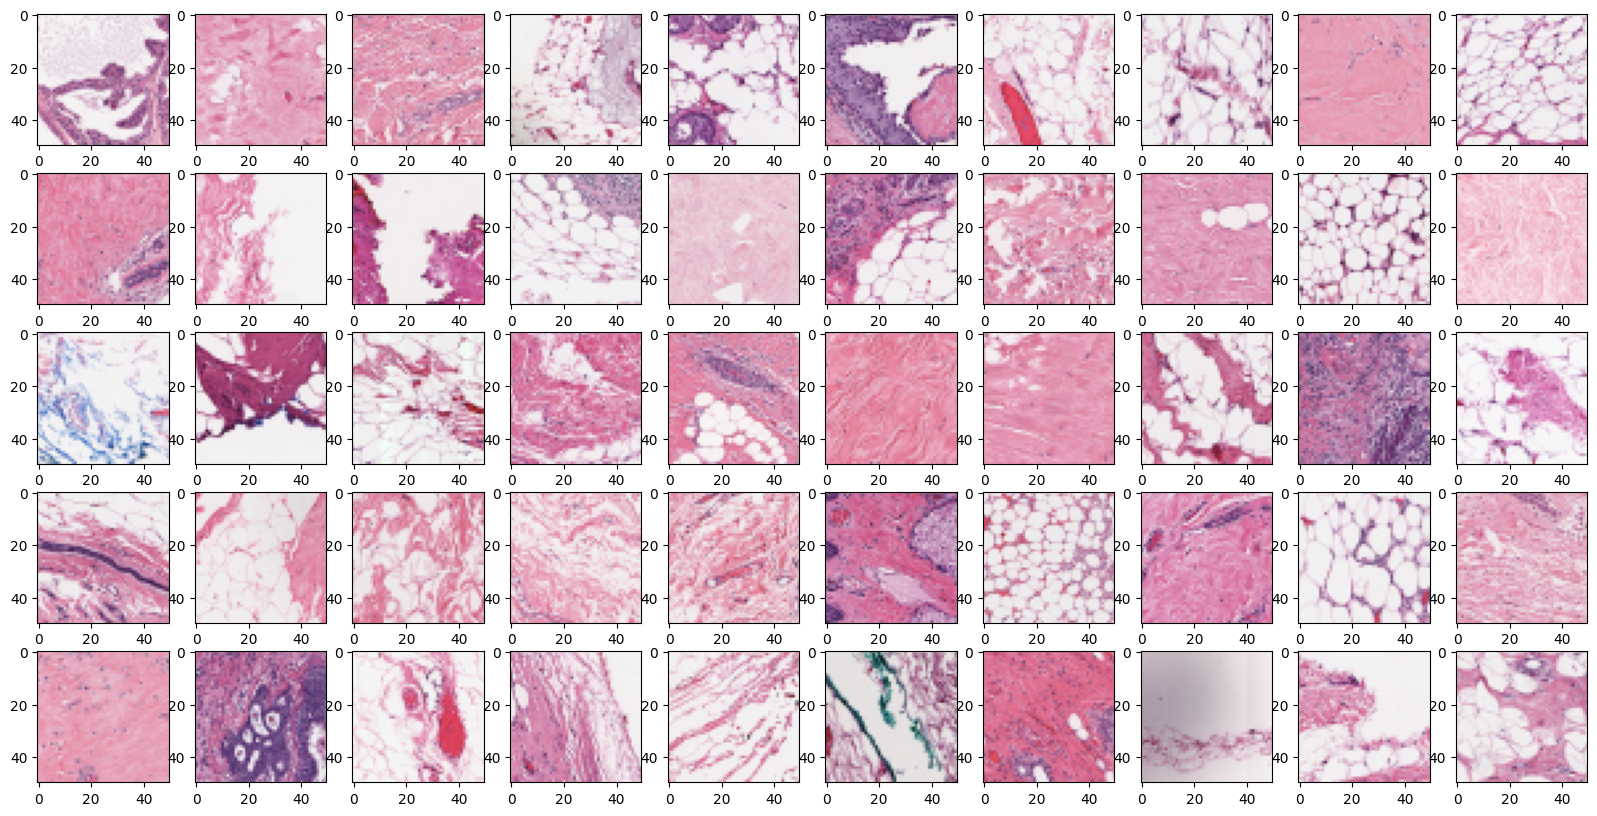

In [17]:
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for idx, (n, m) in enumerate([(n, m) for n in range(5) for m in range(10)]):
    idx = neg_selection[m + 10 * n]
    path = os.path.join(consolidatedImage, data.loc[idx, 'image_id'])
    image = plt.imread(path)
    ax[n, m].imshow(image)
    ax[n, m].grid(False)


### Positive patches

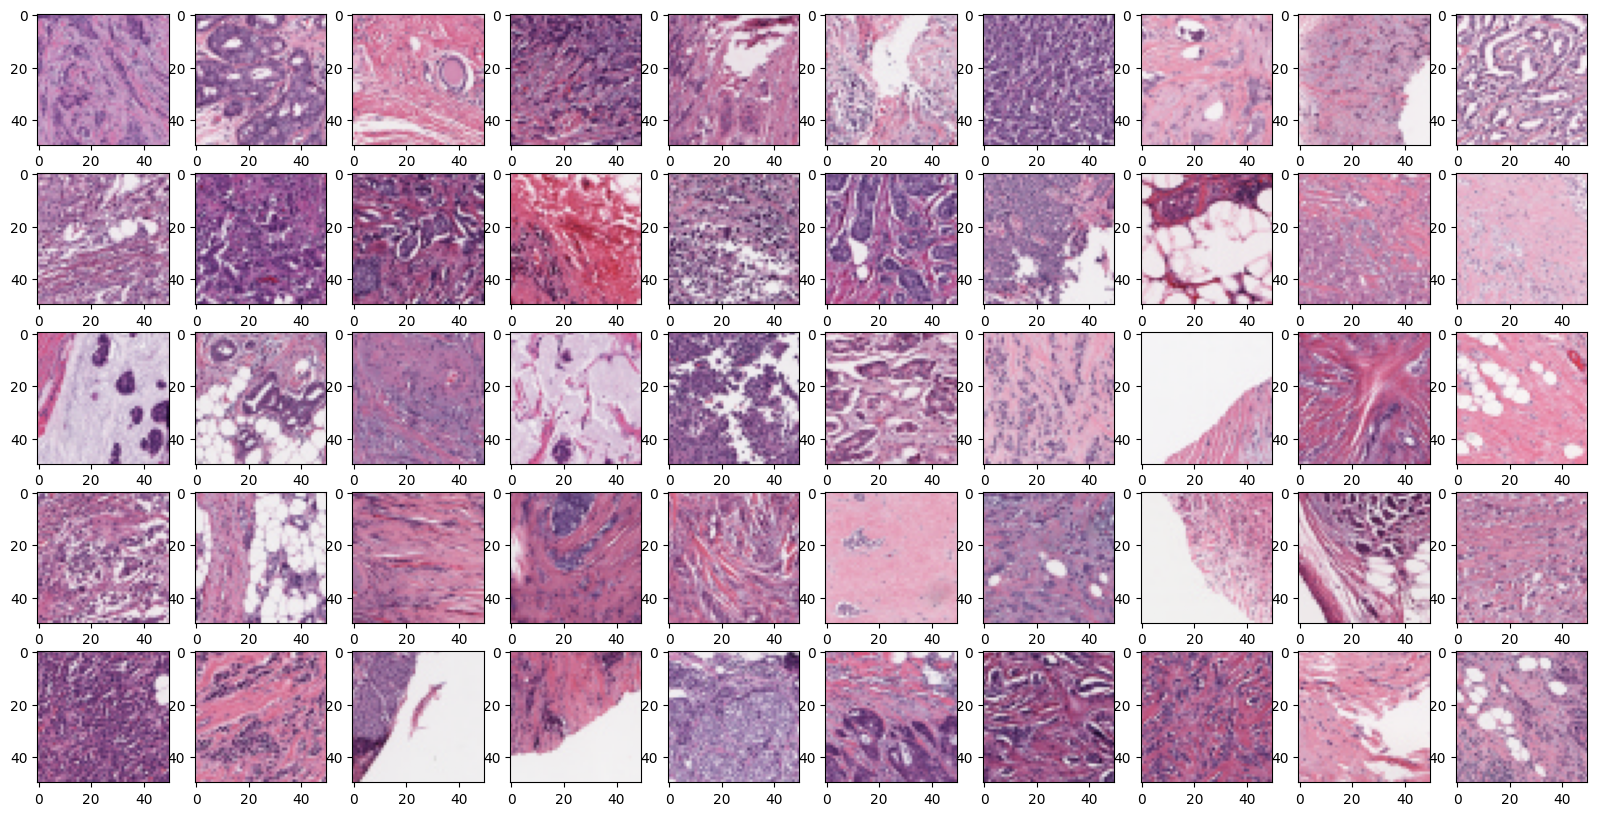

In [18]:
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for idx, (n, m) in enumerate([(n, m) for n in range(5) for m in range(10)]):
    idx = pos_selection[m + 10 * n]
    path = os.path.join(consolidatedImage, data.loc[idx, 'image_id'])
    image = plt.imread(path)
    ax[n, m].imshow(image)
    ax[n, m].grid(False)


The negative patches havea lighter pinkish side with some white on the mjority of them wheras the positive patches darker purple look. Overall it is really diffcult to tell the diffrences just by looking at it

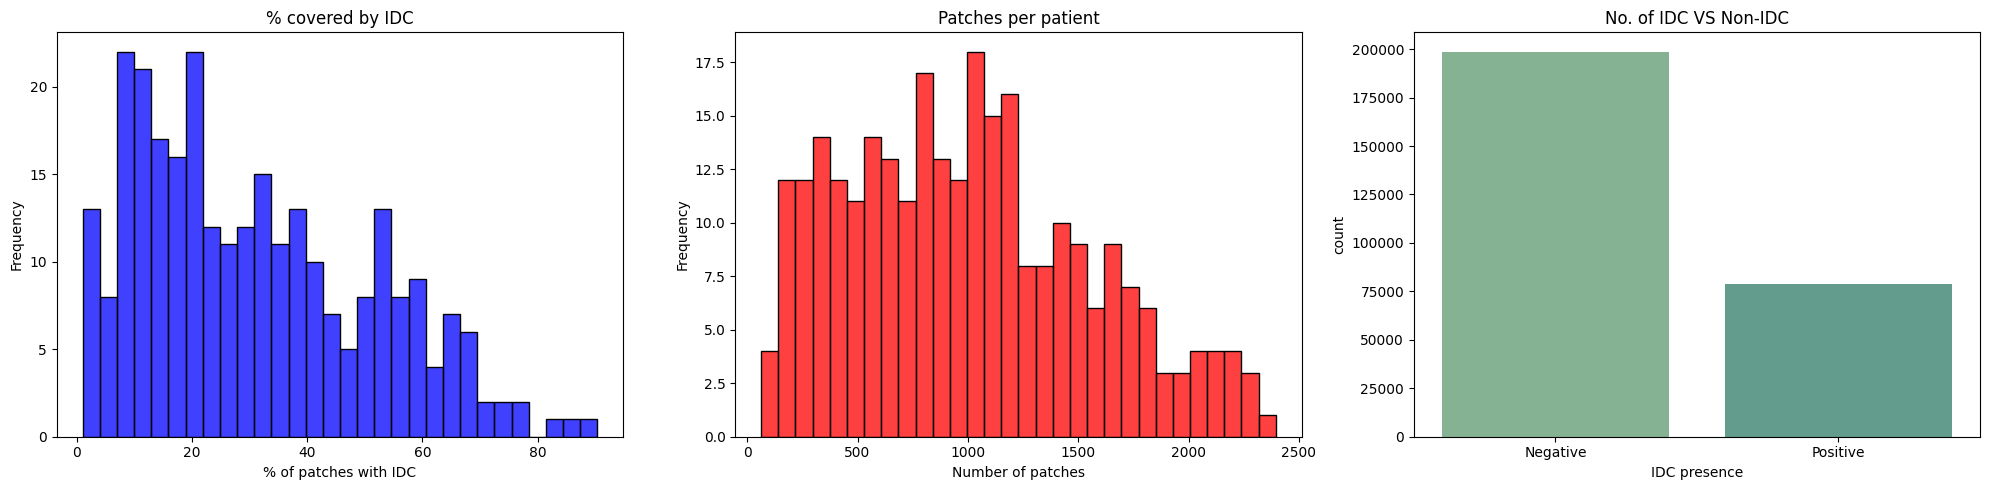

In [19]:
cancer_perc = data.groupby('patient_id').target.value_counts() / data.groupby('patient_id').target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Histogram - Percentage of patches with IDC
sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[0], color='blue', kde=False, bins=30)
ax[0].set_title('% covered by IDC')
ax[0].set_xlabel('% of patches with IDC')
ax[0].set_ylabel('Frequency')

# Plot 2: Histogram - Number of patches per patient
sns.histplot(data.groupby('patient_id').size(), ax=ax[1], color='red', kde=False, bins=30)
ax[1].set_title('Patches per patient')
ax[1].set_xlabel('Number of patches')
ax[1].set_ylabel('Frequency')

# Plot 3: Countplot - Number of patches showing IDC
sns.countplot(data=data, x='target', palette=sns.color_palette("crest"), ax=ax[2])
ax[2].set_title('No. of IDC VS Non-IDC')
ax[2].set_xlabel('IDC presence')
# ax[2].set_xticks([0, 1])  # Set the tick positions
ax[2].set_xticklabels(['Negative', 'Positive'])  # Assign the tick labels

plt.tight_layout()
plt.show()

Insights:
- The majority of the pictures exhibit a relatively small percentage of IDC, while certain images portray a percentage as high as 80%.
- There is significant variation in the quantity of image patches per patient
- The number of images with cancerous cells is disproportionate, hence the dataset is imbalanced.

In [20]:
total_patches = data.shape[0]
print("Total number of patches:", total_patches)

Total number of patches: 277524


# Splitting of dataset

In [21]:
consolidatedImageSplit = os.listdir('E:\FYP\dataset\\consolidatedImageSplit')

In [22]:
len(consolidatedImageSplit)

249772

In [23]:
# 10% of data to be used for testing
test_size = int(0.1 * len(consolidatedImagList))
test_size

27752

In [24]:
# cut a number of files from source into destination folder with 'zeroes' and 'ones' for test set
def split_and_move_files(source_dir, destination_dir, num_files):
    # Get a list of all files in the source directory
    file_list = os.listdir(source_dir)

    # Separate files into class 0 and class 1 lists
    class_0_files = [file for file in file_list if file.endswith("_class0.png")]
    class_1_files = [file for file in file_list if file.endswith("_class1.png")]

    # Shuffle the lists randomly
    random.shuffle(class_0_files)
    random.shuffle(class_1_files)

    # Determine the number of files to split from each class
    num_files_per_class = num_files // 2

    # Create destination directories if they don't exist
    zeros_dir = os.path.join(destination_dir, "zeros")
    ones_dir = os.path.join(destination_dir, "ones")
    
    # skip if file already exists and number of files in zeros and ones are the same
    if (
        os.path.exists(zeros_dir)
        and os.path.exists(ones_dir)
        and len(os.listdir(zeros_dir)) == len(os.listdir(ones_dir))
    ):
        print("Equal number of files already exists in 'zeroes' and 'ones'. Skipping splitting and moving.")
        return

    # Make sure the number of files requested is valid
    if num_files_per_class > len(class_0_files) or num_files_per_class > len(class_1_files):
        print("Error: Insufficient number of files for equal distribution.")
        return

    # Create destination directories if they don't exist
    os.makedirs(zeros_dir, exist_ok=True)
    os.makedirs(ones_dir, exist_ok=True)

    # Copy the files to the corresponding folders and remove them from the source directory
    for file in class_0_files[:num_files_per_class]:
        shutil.copy2(os.path.join(source_dir, file), zeros_dir)
        os.remove(os.path.join(source_dir, file))
    for file in class_1_files[:num_files_per_class]:
        shutil.copy2(os.path.join(source_dir, file), ones_dir)
        os.remove(os.path.join(source_dir, file))

    print(f"Successfully split and moved {num_files_per_class * 2} files with equal class distribution.")




In [25]:
# create a folder contatning class 0 and 1s for test set
source_directory = 'E:\FYP\dataset\\consolidatedImageSplit'
destination_directory = 'E:\FYP\dataset\\test'

split_and_move_files(source_directory, destination_directory, test_size)

Equal number of files already exists in 'zeroes' and 'ones'. Skipping splitting and moving.


In [26]:
data = pd.DataFrame(consolidatedImageSplit, columns=['image_id'])
data['target'] = data['image_id'].apply(extractTarget)
data.head()

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0

In [27]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.20, random_state=101, stratify=y)

In [28]:
print(data_train.shape)
print(data_test.shape)

(199817, 2)
(49955, 2)


In [29]:
data_train

image_id target
23946    10285_idx5_x1901_y901_class0.png      0
53048   12751_idx5_x2151_y2401_class1.png      1
182128    8914_idx5_x951_y1151_class0.png      0
70212    12875_idx5_x751_y1301_class0.png      0
138765  14189_idx5_x2201_y1001_class1.png      1
...                                   ...    ...
67097   12868_idx5_x2501_y1851_class0.png      0
147413  14321_idx5_x1101_y1201_class0.png      0
83068    12897_idx5_x3801_y851_class0.png      0
13013     10272_idx5_x3001_y51_class0.png      0
14993   10273_idx5_x2551_y1201_class1.png      1

[199817 rows x 2 columns]

In [30]:
data_train.image_id

23946      10285_idx5_x1901_y901_class0.png
53048     12751_idx5_x2151_y2401_class1.png
182128      8914_idx5_x951_y1151_class0.png
70212      12875_idx5_x751_y1301_class0.png
138765    14189_idx5_x2201_y1001_class1.png
                        ...                
67097     12868_idx5_x2501_y1851_class0.png
147413    14321_idx5_x1101_y1201_class0.png
83068      12897_idx5_x3801_y851_class0.png
13013       10272_idx5_x3001_y51_class0.png
14993     10273_idx5_x2551_y1201_class1.png
Name: image_id, Length: 199817, dtype: object

In [31]:
train = data_train.image_id
validation  = data_test.image_id

In [32]:
data.set_index('image_id', inplace=True)

In [33]:
data.columns

Index(['target'], dtype='object')

In [34]:
# copy images from main directory into another directory while splitting images into their respective classes
def copy_images_to_directory(source_dir, destination_dir,datas):
    # Create destination directories if they don't exist
    os.makedirs(os.path.join(destination_dir, 'zeros'), exist_ok=True)
    os.makedirs(os.path.join(destination_dir, 'ones'), exist_ok=True)
    
    skipped = 0

    for image in datas:
        fname = image
        target = data.loc[image, 'target']

        if target == '0':
            Class = 'zeros'
        elif target == '1':
            Class = 'ones'
        else:
            continue  # Skip if target is neither 0 nor 1

        src = os.path.join(source_dir, fname)
        dst = os.path.join(destination_dir, Class, fname)

        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
        else:
            skipped += 1

    print(f"Skipped: {skipped} files.")

In [35]:
source = "E:\FYP\dataset\\consolidatedImageSplit"
copy_images_to_directory(source, 'E:\FYP\dataset\\train', train)


Skipped: 199817 files.


In [36]:
copy_images_to_directory(source, 'E:\FYP\dataset\\validation', validation)

Skipped: 49955 files.


In [350]:
print('Negative train set      =',len(os.listdir('E:\FYP\dataset\\train\zeros')))
print('Positive train set      =',len(os.listdir('E:\FYP\dataset\\train\ones')))
print('Negative validation set =',len(os.listdir('E:\FYP\dataset\\validation\zeros')))
print('Positive validation set =',len(os.listdir('E:\FYP\dataset\\validation\ones')))
print('NegativeC test set      =',len(os.listdir('E:\FYP\dataset\\test\zeros')))
print('Positive test set       =',len(os.listdir('E:\FYP\dataset\\test\ones')))

Negative train set      = 147889
Positive train set      = 51928
Negative validation set = 36973
Positive validation set = 12982
NegativeC test set      = 13876
Positive test set       = 13876


In [38]:
# normalize the pixel values of the images by dividing them by 255
dataGeneration = ImageDataGenerator(rescale=1.0/255)

In [39]:
trainSet = dataGeneration.flow_from_directory(
                                        'E:\FYP\dataset\\train',
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical')
validationSet = dataGeneration.flow_from_directory(
                                        'E:\FYP\dataset\\validation',
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical')
testSet = dataGeneration.flow_from_directory(
                                        'E:\FYP\dataset\\test',
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical')

Found 199817 images belonging to 2 classes.
Found 49955 images belonging to 2 classes.
Found 27752 images belonging to 2 classes.


## Adjust class labels

In [40]:
# check the class labels
class_labels = trainSet.class_indices
print(class_labels)

{'ones': 0, 'zeros': 1}


In [41]:
# Modify class labels for training, validation and test set
class_labels = {'ones': 1, 'zeros': 0}
trainSet.class_indices = class_labels
validationSet.class_indices = class_labels
testSet.class_indices = class_labels

In [42]:
# double check labels are correct
train_labels = trainSet.class_indices
validation_labels = validationSet.class_indices
test_labels = testSet.class_indices
print(train_labels)
print(validation_labels)
print(test_labels)

{'ones': 1, 'zeros': 0}
{'ones': 1, 'zeros': 0}
{'ones': 1, 'zeros': 0}


In [43]:
# check the number of classes in each sety
num_classes1 = len(trainSet.class_indices)
num_classes2 = len(validationSet.class_indices)
num_classes3 = len(testSet.class_indices)

print("Number of classes:", num_classes1)
print("Number of classes:", num_classes2)
print("Number of classes:", num_classes3)

Number of classes: 2
Number of classes: 2
Number of classes: 2


# Model Design

In [168]:
# Define the CNN architecture
model1 = Sequential()
model1.add(Conv2D(32, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model1.add(MaxPooling2D())

model1.add(Conv2D(16, (4, 4), activation='relu'))
model1.add(MaxPooling2D())
             
model1.add(Flatten())
             
model1.add(Dense(256, activation='relu'))
model1.add(Dense(2, activation='softmax'))

# Compile the model
model1.compile('adam',loss=BinaryCrossentropy(),metrics=['accuracy'])



In [169]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 47, 47, 32)        1568      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 20, 20, 16)        8208      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 1600)              0         
                                                                 
 dense_34 (Dense)            (None, 256)             

In [170]:
earlyStopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history1 = model1.fit(trainSet, validation_data=validationSet ,epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 138s 7ms/step - loss: 0.3950 - accuracy: 0.8301 - val_loss: 0.3782 - val_accuracy: 0.8476
Epoch 2/50
19982/19982 [==============================] - 142s 7ms/step - loss: 0.3643 - accuracy: 0.8437 - val_loss: 0.3527 - val_accuracy: 0.8538
Epoch 3/50
19982/19982 [==============================] - 136s 7ms/step - loss: 0.3558 - accuracy: 0.8483 - val_loss: 0.3475 - val_accuracy: 0.8521
Epoch 4/50
19982/19982 [==============================] - 135s 7ms/step - loss: 0.3471 - accuracy: 0.8529 - val_loss: 0.3470 - val_accuracy: 0.8547
Epoch 5/50
19982/19982 [==============================] - 143s 7ms/step - loss: 0.3435 - accuracy: 0.8540 - val_loss: 0.3427 - val_accuracy: 0.8577
Epoch 6/50
19982/19982 [==============================] - 147s 7ms/step - loss: 0.3375 - accuracy: 0.8567 - val_loss: 0.3283 - val_accuracy: 0.8615
Epoch 7/50
19982/19982 [==============================] - 147s 7ms/step - loss: 0.3331 - accuracy: 0.8599 - val_

In [171]:
losse1 = pd.DataFrame(history1.history)
losse1.head()

loss  accuracy  val_loss  val_accuracy
0  0.394974  0.830130  0.378185      0.847643
1  0.364305  0.843652  0.352722      0.853828
2  0.355812  0.848286  0.347532      0.852067
3  0.347092  0.852900  0.347005      0.854709
4  0.343463  0.853981  0.342719      0.857712

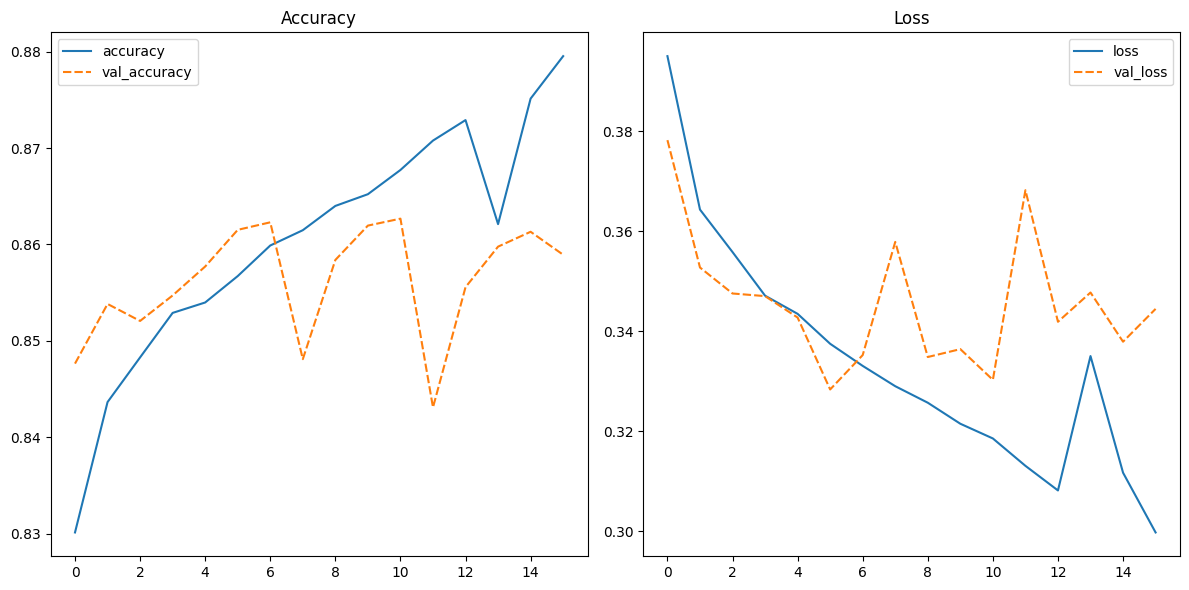

In [172]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse1[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse1[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [173]:
# Step 1: Make predictions
y_pred_probs1 = model1.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred1 = np.argmax(y_pred_probs1, axis=1)

# Step 3: Get true class labels
y_true1 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat1 = confusion_matrix(y_true1, y_pred1)

2776/2776 [==============================] - 16s 5ms/step


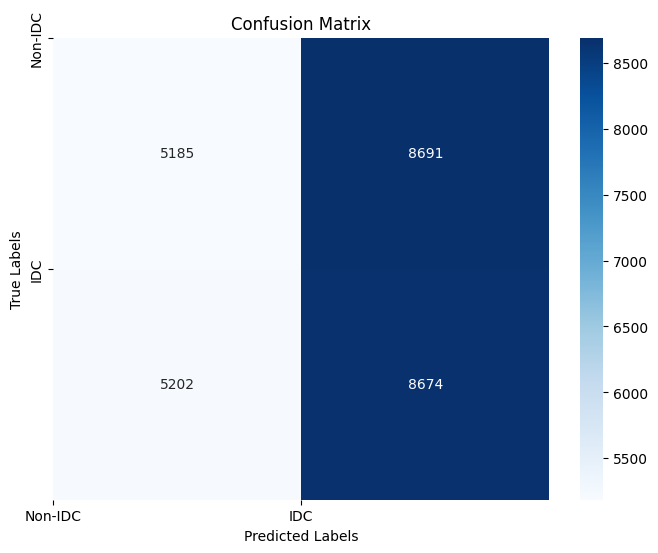

In [174]:
# from left to right: TN,FP,FN,TP
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat1, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])
plt.yticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])

# Display the plot
plt.show()

In [351]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat1[0, 0]
FP = confusion_mat1[0, 1]
FN = confusion_mat1[1, 0]
TP = confusion_mat1[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy1 = (TP + TN) / (TP + TN + FP + FN)
precision1 = TP / (TP + FP)
recall1 = TP / (TP + FN)
f1_score1 = 2 * (precision1 * recall1) / (precision1 + recall1)

print("Accuracy:", accuracy1)
print("Precision:", precision1)
print("Recall:", recall1)
print("F1 Score:", f1_score1)


Accuracy: 0.49938743153646586
Precision: 0.4995105096458393
Recall: 0.6251081003170943
F1 Score: 0.5552959252264653


In [176]:
model1.evaluate(testSet)

2776/2776 [==============================] - 16s 5ms/step - loss: 0.4473 - accuracy: 0.8025


[0.4472648799419403, 0.8025007247924805]

### 2

In [53]:
model2 = Sequential()
model2.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model2.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(.3))

model2.add(Flatten())

model2.add(Dense(256,activation='relu'))

model2.add(Dense(2,activation='softmax'))

model2.compile('adam',loss=BinaryCrossentropy(),metrics=['accuracy'])



In [54]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 47, 47, 32)        1568      
                                                                 
 conv2d_4 (Conv2D)           (None, 44, 44, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 15488)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3965184   
                                                      

In [55]:
history2 = model2.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 204s 10ms/step - loss: 0.3836 - accuracy: 0.8331 - val_loss: 0.3425 - val_accuracy: 0.8513
Epoch 2/50
19982/19982 [==============================] - 190s 10ms/step - loss: 0.3492 - accuracy: 0.8511 - val_loss: 0.3314 - val_accuracy: 0.8603
Epoch 3/50
19982/19982 [==============================] - 185s 9ms/step - loss: 0.3403 - accuracy: 0.8552 - val_loss: 0.3260 - val_accuracy: 0.8618
Epoch 4/50
19982/19982 [==============================] - 189s 9ms/step - loss: 0.3313 - accuracy: 0.8576 - val_loss: 0.3271 - val_accuracy: 0.8592
Epoch 5/50
19982/19982 [==============================] - 190s 10ms/step - loss: 0.3260 - accuracy: 0.8603 - val_loss: 0.3602 - val_accuracy: 0.8464
Epoch 6/50
19982/19982 [==============================] - 162s 8ms/step - loss: 0.3195 - accuracy: 0.8632 - val_loss: 0.3305 - val_accuracy: 0.8623
Epoch 7/50
19982/19982 [==============================] - 152s 8ms/step - loss: 0.3334 - accuracy: 0.8583 - v

In [56]:
losse2 = pd.DataFrame(history2.history)
losse2.head()

loss  accuracy  val_loss  val_accuracy
0  0.383568  0.833137  0.342531      0.851326
1  0.349205  0.851054  0.331419      0.860334
2  0.340281  0.855218  0.326021      0.861816
3  0.331289  0.857640  0.327121      0.859233
4  0.325964  0.860312  0.360227      0.846402

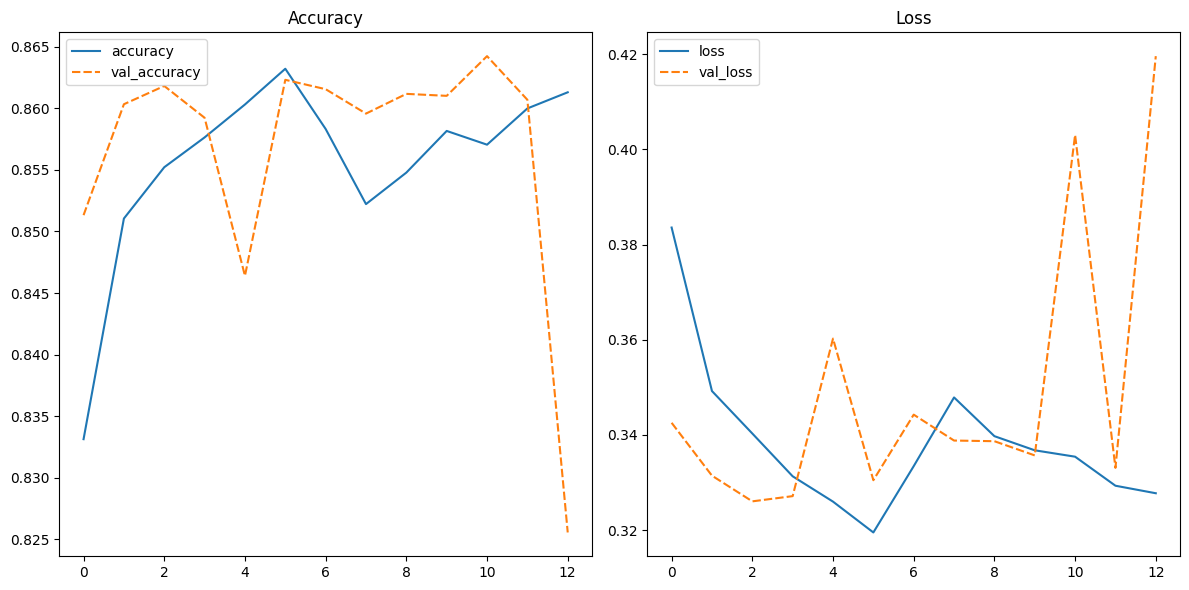

In [57]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse2[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse2[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [58]:
# Step 1: Make predictions
y_pred_probs2 = model2.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred2 = np.argmax(y_pred_probs2, axis=1)

# Step 3: Get true class labels
y_true2 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat2 = confusion_matrix(y_true2, y_pred2)

2776/2776 [==============================] - 25s 9ms/step


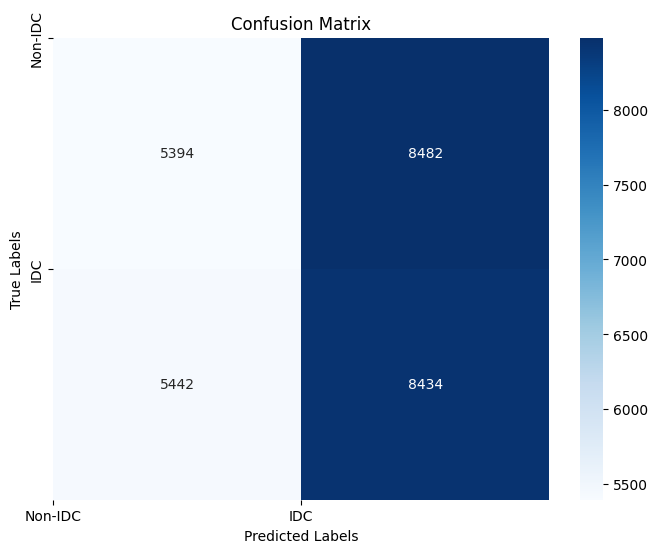

In [59]:
# from left to right: TN,FP,FN,TP
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat2, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])
plt.yticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])

# Display the plot
plt.show()

In [352]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat2[0, 0]
FP = confusion_mat2[0, 1]
FN = confusion_mat2[1, 0]
TP = confusion_mat2[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy2 = (TP + TN) / (TP + TN + FP + FN)
precision2 = TP / (TP + FP)
recall2 = TP / (TP + FN)
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)

print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f1_score2)

Accuracy: 0.4982703949264918
Precision: 0.49858122487585715
Recall: 0.6078120495820121
F1 Score: 0.5478046245778123


In [61]:
model2.evaluate(testSet)

2776/2776 [==============================] - 14s 5ms/step - loss: 0.4301 - accuracy: 0.8098


[0.4301227033138275, 0.809815526008606]

### 3 - number of layers

In [62]:
model3 = Sequential()
model3.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model3.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model3.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
model3.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
model3.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
model3.add(MaxPool2D(pool_size=(1,1)))

model3.add(Conv2D(filters=128,kernel_size=(4,4),activation='relu'))
model3.add(Conv2D(filters=128,kernel_size=(4,4),activation='relu'))
model3.add(Conv2D(filters=128,kernel_size=(4,4),activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Dropout(.3))

model3.add(Flatten())

model3.add(Dense(256,activation='relu'))
model3.add(Dense(2,activation='softmax'))

model3.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])


In [63]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        1568      
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 32)        16416     
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 41, 32)        16416     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 64)        32832     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        65600     
                                                      

In [64]:
history3 = model3.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)


Epoch 1/50
19982/19982 [==============================] - 216s 11ms/step - loss: 0.5741 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401
Epoch 2/50
19982/19982 [==============================] - 211s 11ms/step - loss: 0.5734 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401
Epoch 3/50
19982/19982 [==============================] - 209s 10ms/step - loss: 0.5734 - accuracy: 0.7401 - val_loss: 0.5731 - val_accuracy: 0.7401
Epoch 4/50
19982/19982 [==============================] - 209s 10ms/step - loss: 0.5733 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401
Epoch 5/50
19982/19982 [==============================] - 210s 11ms/step - loss: 0.5732 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401
Epoch 6/50
19982/19982 [==============================] - 212s 11ms/step - loss: 0.5732 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401
Epoch 7/50
19982/19982 [==============================] - 212s 11ms/step - loss: 0.5731 - accuracy: 0.7401

In [65]:
# convert results to dataframe
losse3 = pd.DataFrame(history3.history)
losse3.head()

loss  accuracy  val_loss  val_accuracy
0  0.574055  0.740127  0.572989      0.740126
1  0.573421  0.740122  0.572976      0.740126
2  0.573376  0.740122  0.573055      0.740126
3  0.573255  0.740122  0.572936      0.740126
4  0.573209  0.740122  0.572934      0.740126

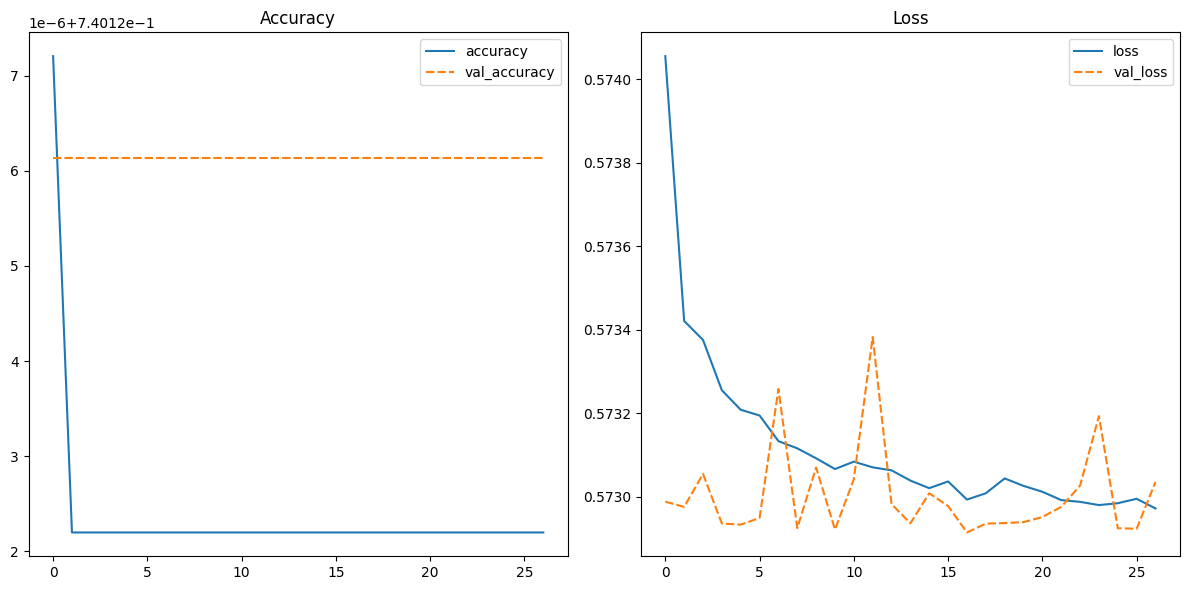

In [66]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse3[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse3[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [67]:
# Step 1: Make predictions
y_pred_probs3 = model3.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred3 = np.argmax(y_pred_probs3, axis=1)

# Step 3: Get true class labels
y_true3 = testSet.labels

# Step 3: Create confusion matrix
confusion_mat3 = confusion_matrix(y_true3, y_pred3)

2776/2776 [==============================] - 27s 10ms/step


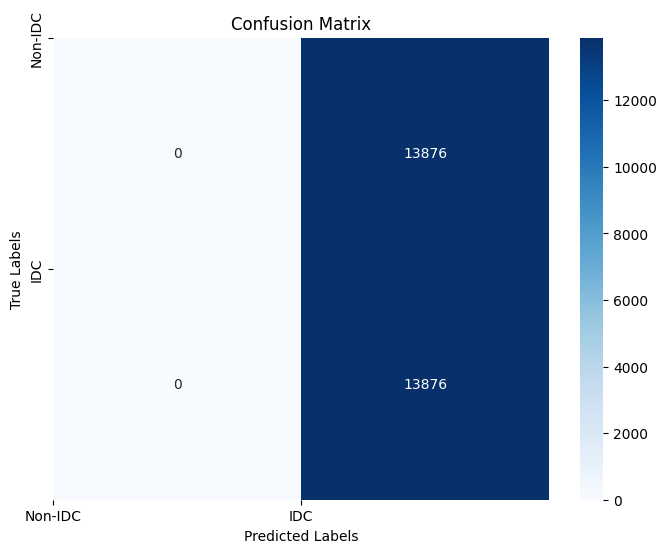

In [68]:
# from left to right: TN,FP,FN,TP
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat3, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])
plt.yticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])

# Display the plot
plt.show()

In [353]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat3[0, 0]
FP = confusion_mat3[0, 1]
FN = confusion_mat3[1, 0]
TP = confusion_mat3[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy3 = (TP + TN) / (TP + TN + FP + FN)
precision3 = TP / (TP + FP)
recall3 = TP / (TP + FN)
f1_score3 = 2 * (precision3 * recall3) / (precision3 + recall3)

print("Accuracy:", accuracy3)
print("Precision:", precision3)
print("Recall:", recall3)
print("F1 Score:", f1_score3)

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


In [70]:
model3.evaluate(testSet)

2776/2776 [==============================] - 14s 5ms/step - loss: 0.8237 - accuracy: 0.5000


[0.8237231373786926, 0.5]

## 4

In [74]:
model4 = Sequential()
model4.add(Conv2D(filters=128,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
model4.add(Conv2D(filters=128,kernel_size=(4,4),activation='relu'))
model4.add(Conv2D(filters=128,kernel_size=(4,4),activation='relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

model4.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
model4.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
model4.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

model4.add(Conv2D(filters=32,kernel_size=(2,2),activation='relu'))
model4.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
model4.add(Conv2D(filters=32,kernel_size=(1,1),activation='relu'))
model4.add(MaxPool2D(pool_size=(1,1)))

model4.add(Dropout(.5))

model4.add(Flatten())

model4.add(Dense(256,activation='relu'))
model4.add(Dense(2,activation='softmax'))

model4.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])


In [75]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 47, 47, 128)       6272      
                                                                 
 conv2d_24 (Conv2D)          (None, 44, 44, 128)       262272    
                                                                 
 conv2d_25 (Conv2D)          (None, 41, 41, 128)       262272    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 17, 17, 64)        131136    
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 64)        65600     
                                                      

In [76]:
history4 = model4.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 353s 18ms/step - loss: 0.5739 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401
Epoch 2/50
19982/19982 [==============================] - 340s 17ms/step - loss: 0.5735 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401
Epoch 3/50
19982/19982 [==============================] - 371s 19ms/step - loss: 0.5733 - accuracy: 0.7401 - val_loss: 0.5737 - val_accuracy: 0.7401
Epoch 4/50
19982/19982 [==============================] - 381s 19ms/step - loss: 0.5733 - accuracy: 0.7401 - val_loss: 0.5742 - val_accuracy: 0.7401
Epoch 5/50
19982/19982 [==============================] - 383s 19ms/step - loss: 0.5733 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401
Epoch 6/50
19982/19982 [==============================] - 358s 18ms/step - loss: 0.5732 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401
Epoch 7/50
19982/19982 [==============================] - 336s 17ms/step - loss: 0.5732 - accuracy: 0.7401

In [77]:
losse4 = pd.DataFrame(history4.history)
losse4.head()

loss  accuracy  val_loss  val_accuracy
0  0.573901  0.740122  0.572955      0.740126
1  0.573468  0.740122  0.572945      0.740126
2  0.573259  0.740122  0.573695      0.740126
3  0.573260  0.740122  0.574165      0.740126
4  0.573263  0.740122  0.572934      0.740126

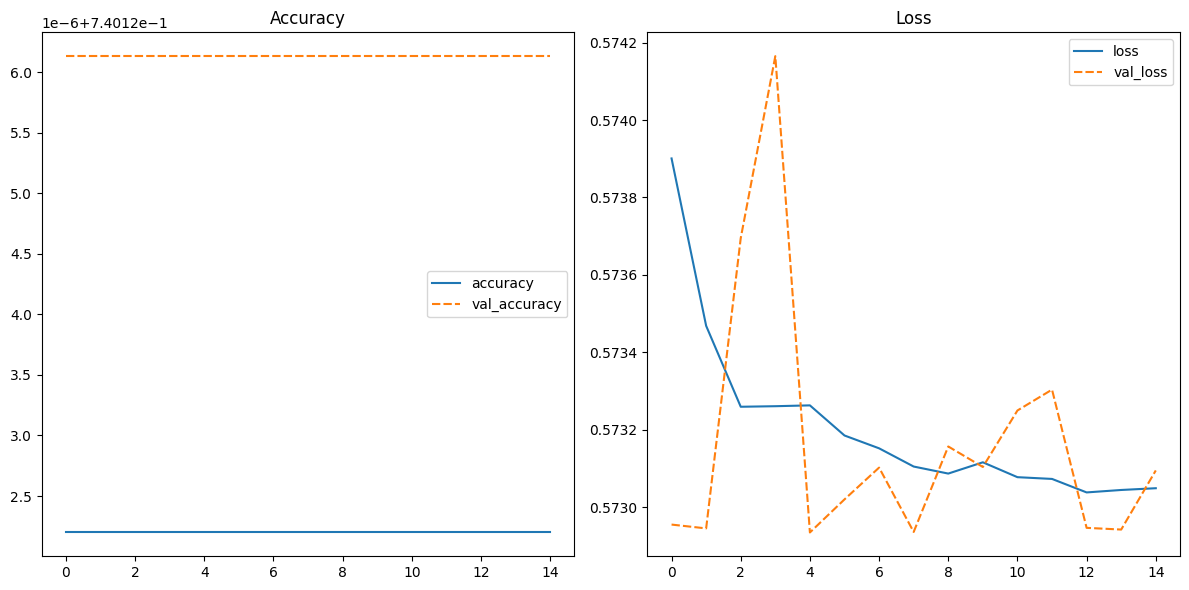

In [79]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse4[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse4[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [80]:
# Step 1: Make predictions
y_pred_probs4 = model4.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred4 = np.argmax(y_pred_probs4, axis=1)

# Step 4: Get true class labels
y_true4 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat4 = confusion_matrix(y_true4, y_pred4)

2776/2776 [==============================] - 27s 9ms/step


In [81]:
print(y_true4)

[0 0 0 ... 1 1 1]


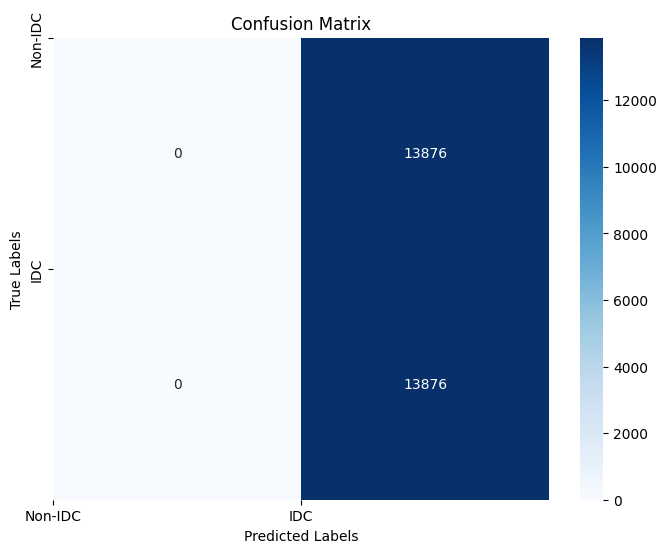

In [82]:
# from left to right: TN,FP,FN,TP
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat4, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])
plt.yticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])

# Display the plot
plt.show()

In [358]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat4[0, 0]
FP = confusion_mat4[0, 1]
FN = confusion_mat4[1, 0]
TP = confusion_mat4[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy4 = (TP + TN) / (TP + TN + FP + FN)
precision4 = TP / (TP + FP)
recall4 = TP / (TP + FN)
f1_score4 = 2 * (precision4 * recall4) / (precision4 + recall4)

print("Accuracy:", accuracy4)
print("Precision:", precision4)
print("Recall:", recall4)
print("F1 Score:", f1_score4)

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


In [84]:
model4.evaluate(testSet)

2776/2776 [==============================] - 20s 7ms/step - loss: 0.8207 - accuracy: 0.5000


[0.8206660747528076, 0.5]

## 5 - Learning rate

In [85]:
# Define the CNN architecture
model5 = Sequential()
model5.add(Conv2D(16, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model5.add(MaxPooling2D())

model5.add(Conv2D(32, (4, 4), activation='relu'))
model5.add(MaxPooling2D())

model5.add(Conv2D(16, (4, 4), activation='relu'))
model5.add(MaxPooling2D())
             
model5.add(Flatten())
             
model5.add(Dense(256, activation='relu'))
model5.add(Dense(2, activation='softmax'))

model5.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy(),metrics=['accuracy'])


In [86]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 47, 47, 16)        784       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 23, 23, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 20, 32)        8224      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 16)          8208      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 3, 3, 16)        

In [87]:
def exponential_decay(epoch):
    initial_learning_rate = 0.01  # Initial learning rate
    decay_rate = 0.9  # Rate at which learning rate will decrease (e.g., 0.9 for 10% decrease)
    new_learning_rate = initial_learning_rate * np.exp(-decay_rate * epoch)
    return new_learning_rate

# Create a callback that updates the learning rate at the end of each epoch
lr_scheduler = LearningRateScheduler(exponential_decay)

In [88]:
history5 = model5.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=[earlyStopping,lr_scheduler])


Epoch 1/50
19982/19982 [==============================] - 157s 8ms/step - loss: 0.5737 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401 - lr: 0.0100
Epoch 2/50
19982/19982 [==============================] - 156s 8ms/step - loss: 0.5731 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401 - lr: 0.0041
Epoch 3/50
19982/19982 [==============================] - 159s 8ms/step - loss: 0.5730 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401 - lr: 0.0017
Epoch 4/50
19982/19982 [==============================] - 155s 8ms/step - loss: 0.5730 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401 - lr: 6.7206e-04
Epoch 5/50
19982/19982 [==============================] - 155s 8ms/step - loss: 0.5729 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401 - lr: 2.7324e-04
Epoch 6/50
19982/19982 [==============================] - 155s 8ms/step - loss: 0.5729 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401 - lr: 1.1109e-04
Epoch 7/50
19982/19982

In [89]:
losse5 = pd.DataFrame(history5.history)
losse5.head()

loss  accuracy  val_loss  val_accuracy        lr
0  0.573684  0.740112  0.573016      0.740126  0.010000
1  0.573068  0.740122  0.573040      0.740126  0.004066
2  0.573005  0.740122  0.572942      0.740126  0.001653
3  0.572954  0.740122  0.572917      0.740126  0.000672
4  0.572943  0.740122  0.572931      0.740126  0.000273

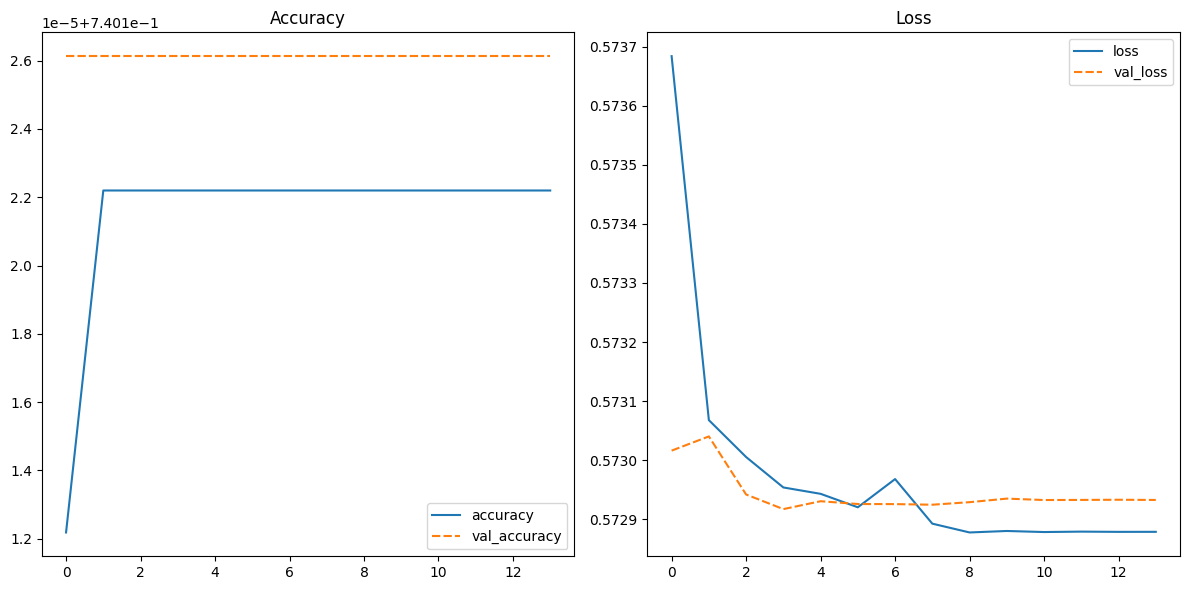

In [90]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse5[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse5[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [91]:
# Step 1: Make predictions
y_pred_probs5 = model5.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred5 = np.argmax(y_pred_probs5, axis=1)

# Step 5: Get true class labels
y_true5 = testSet.labels

# Step 5: Create confusion matrix
confusion_mat5 = confusion_matrix(y_true5, y_pred5)

2776/2776 [==============================] - 12s 4ms/step


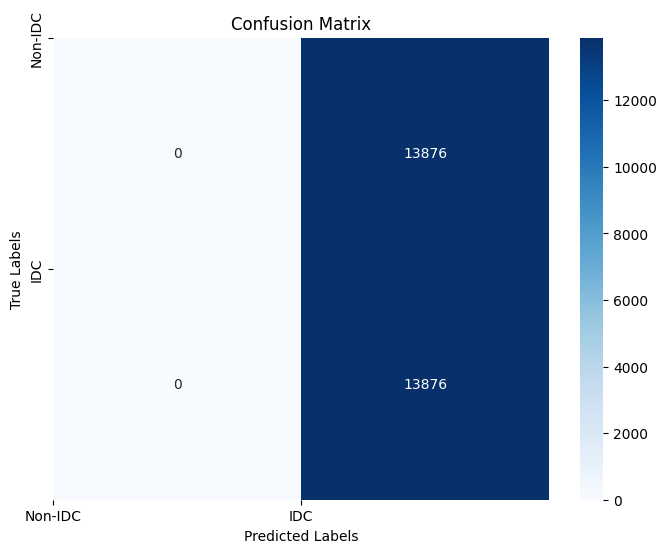

In [92]:
# from left to right: TN,FP,FN,TP
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat5, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])
plt.yticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])

# Display the plot
plt.show()

In [356]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat5[0, 0]
FP = confusion_mat5[0, 1]
FN = confusion_mat5[1, 0]
TP = confusion_mat5[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy5 = (TP + TN) / (TP + TN + FP + FN)
precision5 = TP / (TP + FP)
recall5 = TP / (TP + FN)
f1_score5 = 2 * (precision5 * recall5) / (precision5 + recall5)

print("Accuracy:", accuracy5)
print("Precision:", precision5)
print("Recall:", recall5)
print("F1 Score:", f1_score5)

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


In [94]:
model5.evaluate(testSet)


2776/2776 [==============================] - 12s 4ms/step - loss: 0.8255 - accuracy: 0.5000


[0.8255091309547424, 0.5]

##  6

In [369]:
# Define the CNN architecture
model6 = Sequential()
model6.add(Conv2D(16, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model6.add(MaxPooling2D())

model6.add(Conv2D(32, (4, 4), activation='relu'))
model6.add(MaxPooling2D())

model6.add(Conv2D(16, (4, 4), activation='relu'))
model6.add(MaxPooling2D())
             
model6.add(Flatten())
             
model6.add(Dense(256, activation='relu'))
model6.add(Dense(2, activation='softmax'))

model6.compile(optimizer=Adam(learning_rate=0.01),loss=BinaryCrossentropy(),metrics=['accuracy'])


In [370]:
model6.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 47, 47, 16)        784       
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 23, 23, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 20, 20, 32)        8224      
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 10, 10, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 7, 7, 16)          8208      
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 3, 3, 16)       

In [371]:
def step_decay(epoch):
    initial_learning_rate = 0.01  # Initial learning rate
    drop = 0.5  # Factor by which the learning rate will be reduced
    epochs_drop = 1  # Number of epochs after which learning rate will be reduced
    new_learning_rate = initial_learning_rate * (drop ** (epoch // epochs_drop))
    return new_learning_rate

# Create a callback that updates the learning rate at the end of each epoch
lr_scheduler2 = LearningRateScheduler(step_decay)

In [372]:
history6 = model6.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=[earlyStopping,lr_scheduler2])

Epoch 1/50
19982/19982 [==============================] - 168s 8ms/step - loss: 0.5737 - accuracy: 0.7401 - val_loss: 0.5731 - val_accuracy: 0.7401 - lr: 0.0100
Epoch 2/50
19982/19982 [==============================] - 162s 8ms/step - loss: 0.5731 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401 - lr: 0.0050
Epoch 3/50
19982/19982 [==============================] - 169s 8ms/step - loss: 0.5730 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401 - lr: 0.0025
Epoch 4/50
19982/19982 [==============================] - 172s 9ms/step - loss: 0.5730 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401 - lr: 0.0012
Epoch 5/50
19982/19982 [==============================] - 165s 8ms/step - loss: 0.5730 - accuracy: 0.7401 - val_loss: 0.5730 - val_accuracy: 0.7401 - lr: 6.2500e-04
Epoch 6/50
19982/19982 [==============================] - 159s 8ms/step - loss: 0.5729 - accuracy: 0.7401 - val_loss: 0.5729 - val_accuracy: 0.7401 - lr: 3.1250e-04
Epoch 7/50
19982/19982 [==

In [373]:
losse6 = pd.DataFrame(history6.history)
losse6.head()

loss  accuracy  val_loss  val_accuracy        lr
0  0.573681  0.740082  0.573064      0.740126  0.010000
1  0.573071  0.740122  0.572965      0.740126  0.005000
2  0.573045  0.740122  0.572925      0.740126  0.002500
3  0.572964  0.740122  0.572962      0.740126  0.001250
4  0.572953  0.740122  0.572954      0.740126  0.000625

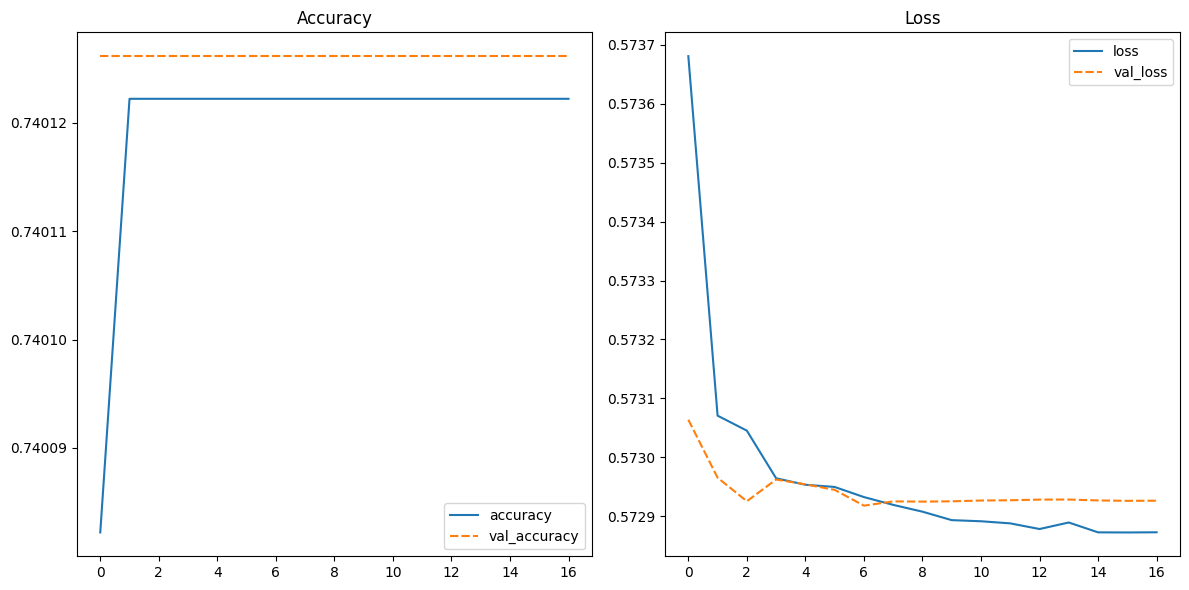

In [374]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse6[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse6[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [378]:
# Step 1: Make predictions
y_pred_probs6 = model6.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred6 = np.argmax(y_pred_probs6, axis=1)

# Step 6: Get true class labels
y_true6 = testSet.labels

# Step 6: Create confusion matrix
confusion_mat6 = confusion_matrix(y_true6, y_pred6)

2776/2776 [==============================] - 15s 5ms/step


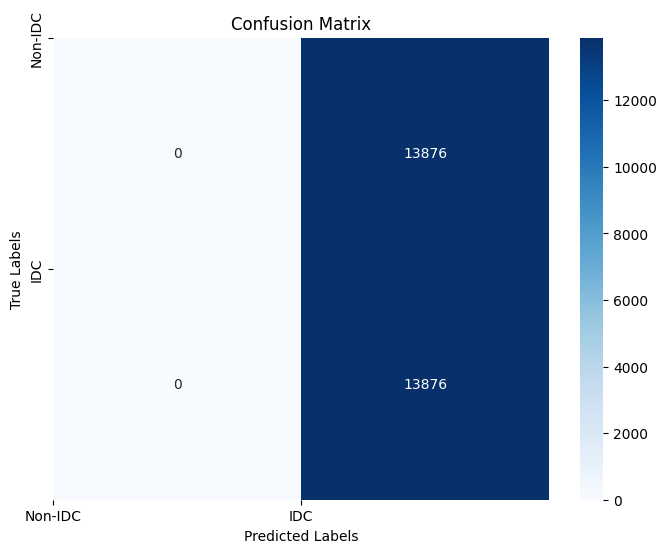

In [379]:
# from left to right: TN,FP,FN,TP
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat6, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])
plt.yticks(ticks=[0, 1], labels=['Non-IDC', 'IDC'])

# Display the plot
plt.show()

In [380]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat6[0, 0]
FP = confusion_mat6[0, 1]
FN = confusion_mat6[1, 0]
TP = confusion_mat6[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy6 = (TP + TN) / (TP + TN + FP + FN)
precision6 = TP / (TP + FP)
recall6 = TP / (TP + FN)
f1_score6 = 2 * (precision6 * recall6) / (precision6 + recall6)

print("Accuracy:", accuracy6)
print("Precision:", precision6)
print("Recall:", recall6)
print("F1 Score:", f1_score6)

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


In [381]:
model6.evaluate(testSet)

2776/2776 [==============================] - 17s 6ms/step - loss: 0.8238 - accuracy: 0.5000


[0.8237965703010559, 0.5]

#  Determine which form of model's combination provides better results

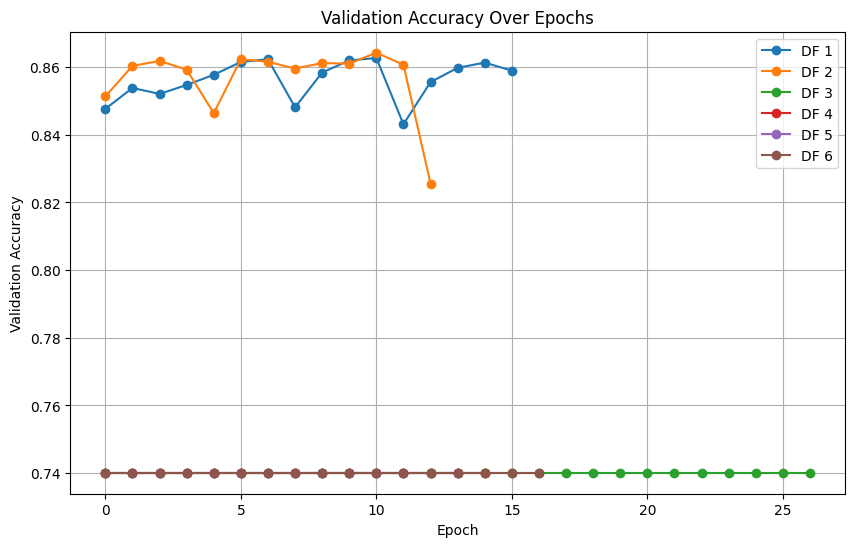

In [382]:
# Assuming you have 5 dataframes named df1, df2, df3, df4, and df5
dfs = [losse1, losse2, losse3, losse4, losse5, losse6]

# Create a line plot for val_accuracy for each dataframe
plt.figure(figsize=(10, 6))

for i, df in enumerate(dfs):
    plt.plot(df.index, df['val_accuracy'], label=f'DF {i+1}', marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

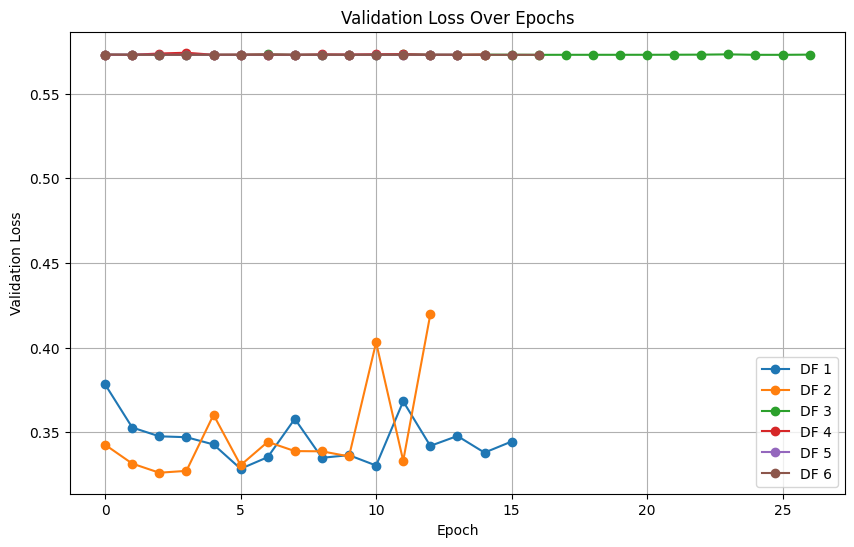

In [383]:
# Assuming you have 5 dataframes named df1, df2, df3, df4, and df5
dfs = [losse1, losse2, losse3, losse4, losse5, losse6]

# Create a line plot for val_accuracy for each dataframe
plt.figure(figsize=(10, 6))

for i, df in enumerate(dfs):
    plt.plot(df.index, df['val_loss'], label=f'DF {i+1}', marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

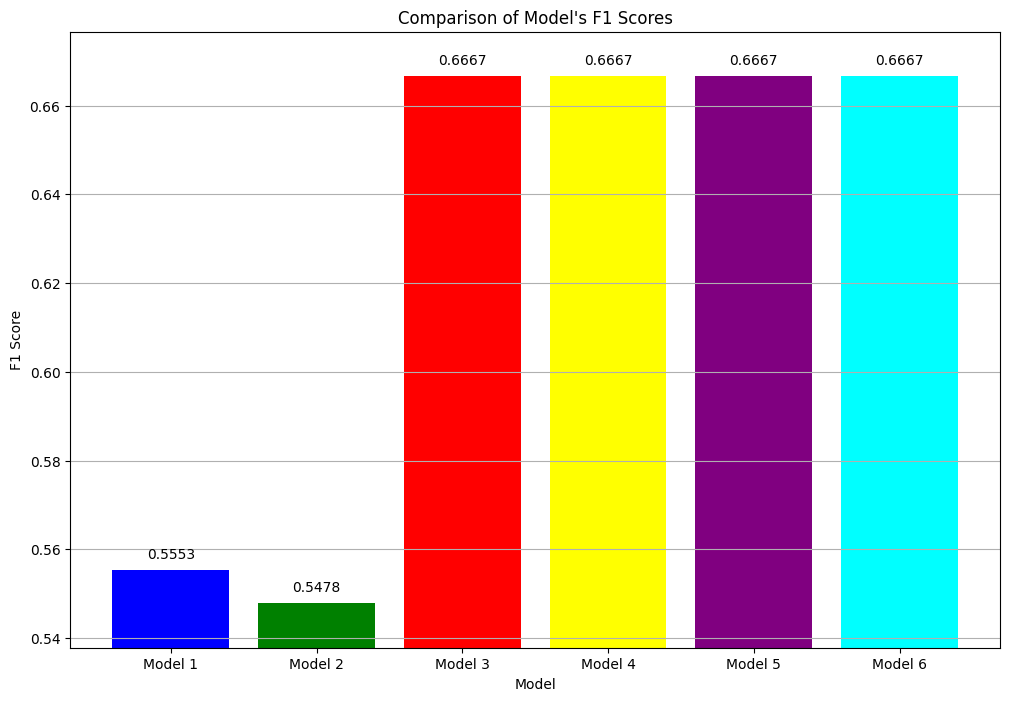

In [390]:
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
f1_scores = [f1_score1, f1_score2, f1_score3, f1_score4, f1_score5, f1_score6] 
minLimit = min(f1_scores)
maxLimit = max(f1_scores)

# Create the bar chart
plt.figure(figsize=(12, 8))  

# Plot the accuracy scores as bars
plt.bar(model_names, f1_scores, color=['blue', 'green', 'red','Yellow','purple','Cyan'])

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title("Comparison of Model's F1 Scores")

for x, y in zip(model_names, f1_scores):
    plt.text(x, y + 0.002, f'{y:.4}', ha='center', va='bottom')

# Show the chart
plt.ylim(minLimit-0.01, maxLimit+0.01)  # Set the y-axis limits 
plt.grid(axis='y')
plt.show()

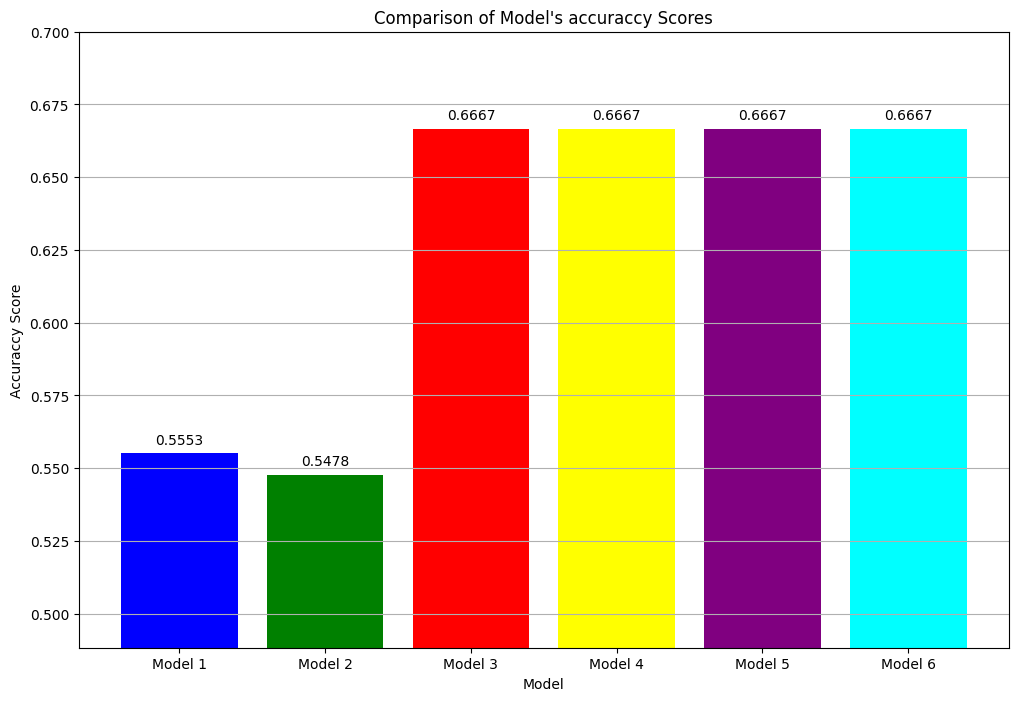

In [402]:
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
accuraccy = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6] 
minLimit = min(accuraccy)
maxLimit = max(accuraccy)

# Create the bar chart
plt.figure(figsize=(12, 8))  

# Plot the accuracy scores as bars
plt.bar(model_names, f1_scores, color=['blue', 'green', 'red','Yellow','purple','Cyan'])

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('Accuraccy Score')
plt.title("Comparison of Model's accuraccy Scores")

for x, y in zip(model_names, f1_scores):
    plt.text(x, y + 0.002, f'{y:.4}', ha='center', va='bottom')

# Show the chart
plt.ylim(minLimit-0.01, maxLimit+0.2)  # Set the y-axis limits 
plt.grid(axis='y')
plt.show()

Based on our dataset, it is imbalanced so instead of focusing on the accuracy of the model, more emphasis will be put on the f1-score. As we can see models 3,4,5,6 all have the same F1-score of 0.66 which is the highest but upon closer look at their validation loss, we can tell that from the start till the end of the training the loss has stagnated which tells us that the models have a high possibility of overfitting and will thus be unreliable in unseen data. Hence we will go with model 1 which has a consistently lower validation score and high accuracy score.

## Modify the numbers and parameters of model 1

## 7

In [112]:
# Define the CNN architecture
model7 = Sequential()
model7.add(Conv2D(128, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model7.add(MaxPooling2D())

model7.add(Conv2D(256, (4, 4), activation='relu'))
model7.add(MaxPooling2D())

model7.add(Conv2D(128, (4, 4), activation='relu'))
model7.add(MaxPooling2D())
             
model7.add(Flatten())
             
model7.add(Dense(256, activation='relu'))
model7.add(Dense(2, activation='softmax'))

# Compile the model
model7.compile('adam',loss=BinaryCrossentropy(),metrics=['accuracy'])



In [113]:
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 47, 47, 128)       6272      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 20, 20, 256)       524544    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 7, 7, 128)         524416    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 3, 3, 128)       

In [114]:
history7 = model7.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 213s 11ms/step - loss: 0.4056 - accuracy: 0.8232 - val_loss: 0.3958 - val_accuracy: 0.8334
Epoch 2/50
19982/19982 [==============================] - 206s 10ms/step - loss: 0.3535 - accuracy: 0.8502 - val_loss: 0.3487 - val_accuracy: 0.8527
Epoch 3/50
19982/19982 [==============================] - 219s 11ms/step - loss: 0.3415 - accuracy: 0.8556 - val_loss: 0.3318 - val_accuracy: 0.8611
Epoch 4/50
19982/19982 [==============================] - 216s 11ms/step - loss: 0.3341 - accuracy: 0.8593 - val_loss: 0.3727 - val_accuracy: 0.8469
Epoch 5/50
19982/19982 [==============================] - 218s 11ms/step - loss: 0.3301 - accuracy: 0.8619 - val_loss: 0.3232 - val_accuracy: 0.8661
Epoch 6/50
19982/19982 [==============================] - 215s 11ms/step - loss: 0.3473 - accuracy: 0.8538 - val_loss: 0.3518 - val_accuracy: 0.8513
Epoch 7/50
19982/19982 [==============================] - 186s 9ms/step - loss: 0.3476 - accuracy: 0.8532 

In [213]:
losse7 = pd.DataFrame(history7.history)
losse7.head()

loss  accuracy  val_loss  val_accuracy
0  0.405635  0.823248  0.395821      0.833370
1  0.353482  0.850178  0.348737      0.852727
2  0.341534  0.855598  0.331838      0.861135
3  0.334137  0.859341  0.372711      0.846942
4  0.330106  0.861854  0.323204      0.866059

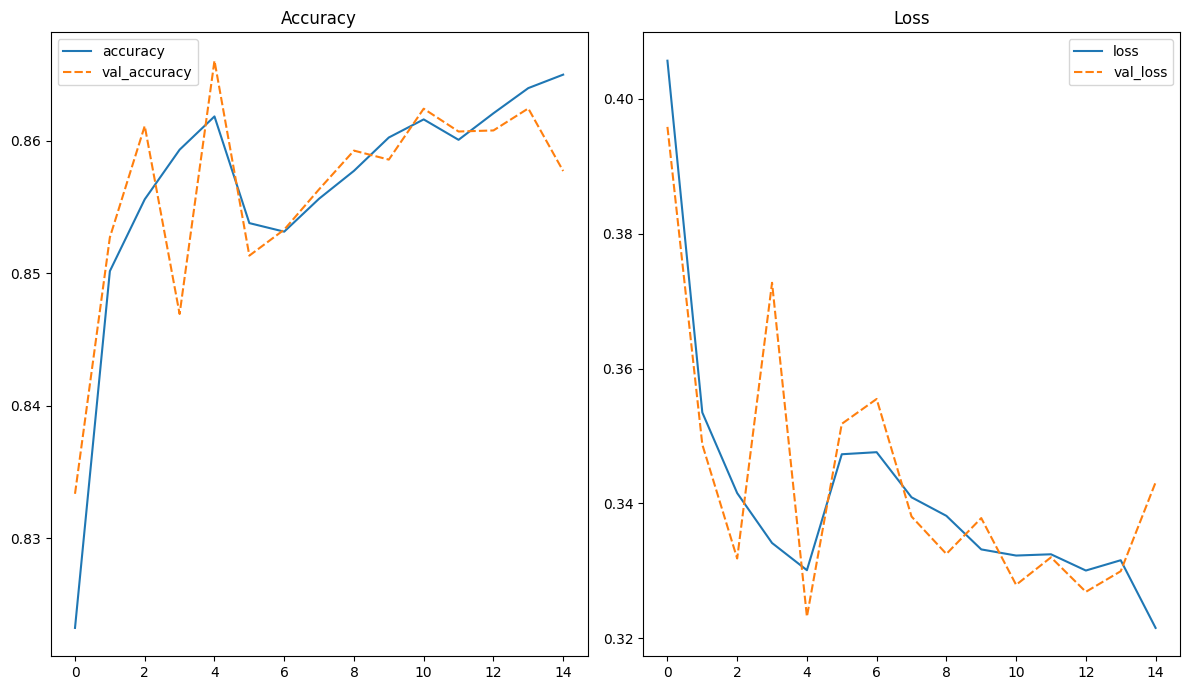

In [214]:
plt.figure(figsize=(12, 7))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse7[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse7[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [215]:
# Step 1: Make predictions
y_pred_probs7 = model7.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred7 = np.argmax(y_pred_probs7, axis=1)

# Step 4: Get true class labels
y_true7 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat7 = confusion_matrix(y_true7, y_pred7)

2776/2776 [==============================] - 15s 5ms/step


In [256]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat7[0, 0]
FP = confusion_mat7[0, 1]
FN = confusion_mat7[1, 0]
TP = confusion_mat7[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy7 = (TP + TN) / (TP + TN + FP + FN)
precision7 = TP / (TP + FP)
recall7 = TP / (TP + FN)
f1_score7 = 2 * (precision7 * recall7) / (precision7 + recall7)

print("Accuracy:", accuracy7)
print("Precision:", precision7)
print("Recall:", recall7)
print("F1 Score:", f1_score7)

Accuracy: 0.4988108965119631
Precision: 0.4990769230769231
Recall: 0.6429086191986163
F1 Score: 0.561935057163554


In [217]:
model7.evaluate(testSet)

2776/2776 [==============================] - 16s 5ms/step - loss: 0.4624 - accuracy: 0.7975


[0.46238797903060913, 0.7974560260772705]

## 8 

In [123]:
# Define the CNN architecture
model8 = Sequential()
model8.add(Conv2D(64, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model8.add(MaxPooling2D())

model8.add(Conv2D(128, (4, 4), activation='relu'))
model8.add(MaxPooling2D())

model8.add(Conv2D(64, (4, 4), activation='relu'))
model8.add(MaxPooling2D())
             
model8.add(Flatten())
             
model8.add(Dense(256, activation='relu'))
model8.add(Dense(2, activation='softmax'))

# Compile the model
model8.compile('adam',loss=BinaryCrossentropy(),metrics=['accuracy'])



In [124]:
model8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 47, 47, 64)        3136      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 20, 20, 128)       131200    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 7, 7, 64)          131136    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 3, 3, 64)       

In [125]:
history8 = model8.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 152s 8ms/step - loss: 0.3996 - accuracy: 0.8285 - val_loss: 0.3549 - val_accuracy: 0.8501
Epoch 2/50
19982/19982 [==============================] - 153s 8ms/step - loss: 0.3580 - accuracy: 0.8481 - val_loss: 0.3789 - val_accuracy: 0.8395
Epoch 3/50
19982/19982 [==============================] - 152s 8ms/step - loss: 0.3447 - accuracy: 0.8534 - val_loss: 0.3384 - val_accuracy: 0.8607
Epoch 4/50
19982/19982 [==============================] - 152s 8ms/step - loss: 0.3364 - accuracy: 0.8576 - val_loss: 0.3403 - val_accuracy: 0.8566
Epoch 5/50
19982/19982 [==============================] - 150s 7ms/step - loss: 0.3305 - accuracy: 0.8602 - val_loss: 0.3411 - val_accuracy: 0.8650
Epoch 6/50
19982/19982 [==============================] - 152s 8ms/step - loss: 0.3509 - accuracy: 0.8517 - val_loss: 0.3452 - val_accuracy: 0.8579
Epoch 7/50
19982/19982 [==============================] - 149s 7ms/step - loss: 0.3459 - accuracy: 0.8537 - val_

In [126]:
losse8 = pd.DataFrame(history8.history)
losse8.head()

loss  accuracy  val_loss  val_accuracy
0  0.399605  0.828478  0.354891      0.850145
1  0.358024  0.848126  0.378914      0.839536
2  0.344739  0.853436  0.338381      0.860695
3  0.336432  0.857565  0.340292      0.856611
4  0.330488  0.860182  0.341057      0.865039

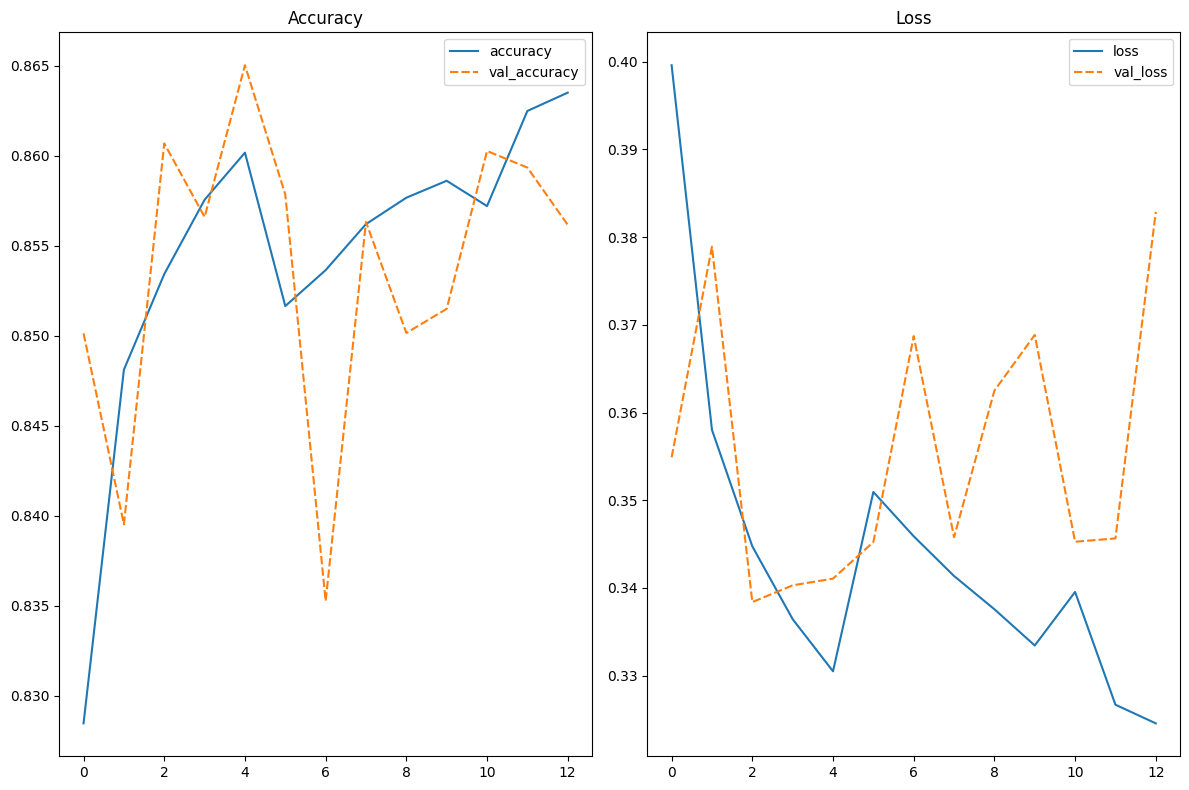

In [127]:
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse8[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse8[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [240]:
# Step 1: Make predictions
y_pred_probs8 = model8.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred8 = np.argmax(y_pred_probs8, axis=1)

# Step 4: Get true class labels
y_true8 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat8 = confusion_matrix(y_true8, y_pred8)

2776/2776 [==============================] - 15s 5ms/step


In [255]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat8[0, 0]
FP = confusion_mat8[0, 1]
FN = confusion_mat8[1, 0]
TP = confusion_mat8[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy8 = (TP + TN) / (TP + TN + FP + FN)
precision8 = TP / (TP + FP)
recall8 = TP / (TP + FN)
f1_score8 = 2 * (precision8 * recall8) / (precision8 + recall8)

print("Accuracy:", accuracy8)
print("Precision:", precision8)
print("Recall:", recall8)
print("F1 Score:", f1_score8)

Accuracy: 0.502306140098011
Precision: 0.5017746228926353
Recall: 0.6520611127125973
F1 Score: 0.5671305001880406


In [130]:
model8.evaluate(testSet)

2776/2776 [==============================] - 13s 5ms/step - loss: 0.4939 - accuracy: 0.7881


[0.4938979148864746, 0.788123369216919]

## 9

In [205]:
# Define the CNN architecture
model9 = Sequential()
model9.add(Conv2D(256, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model9.add(MaxPooling2D())

model9.add(Conv2D(128, (4, 4), activation='relu'))
model9.add(MaxPooling2D())

model9.add(Conv2D(64, (4, 4), activation='relu'))
model9.add(MaxPooling2D())

model9.add(Conv2D(32, (2, 2), activation='relu'))
model9.add(MaxPooling2D())
             
model9.add(Flatten())
             
model9.add(Dense(256, activation='relu'))
model9.add(Dense(2, activation='softmax'))

# Compile the model
model9.compile('adam',loss=BinaryCrossentropy(),metrics=['accuracy'])


In [206]:
model9.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 47, 47, 256)       12544     
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 23, 23, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_111 (Conv2D)         (None, 20, 20, 128)       524416    
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_112 (Conv2D)         (None, 7, 7, 64)          131136    
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 3, 3, 64)       

In [207]:
history9 = model9.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 179s 9ms/step - loss: 0.4060 - accuracy: 0.8255 - val_loss: 0.3716 - val_accuracy: 0.8453
Epoch 2/50
19982/19982 [==============================] - 178s 9ms/step - loss: 0.3615 - accuracy: 0.8465 - val_loss: 0.3720 - val_accuracy: 0.8431
Epoch 3/50
19982/19982 [==============================] - 186s 9ms/step - loss: 0.3494 - accuracy: 0.8513 - val_loss: 0.3607 - val_accuracy: 0.8508
Epoch 4/50
19982/19982 [==============================] - 183s 9ms/step - loss: 0.3425 - accuracy: 0.8548 - val_loss: 0.3376 - val_accuracy: 0.8578
Epoch 5/50
19982/19982 [==============================] - 184s 9ms/step - loss: 0.3373 - accuracy: 0.8573 - val_loss: 0.3302 - val_accuracy: 0.8585
Epoch 6/50
19982/19982 [==============================] - 182s 9ms/step - loss: 0.3324 - accuracy: 0.8588 - val_loss: 0.3289 - val_accuracy: 0.8607
Epoch 7/50
19982/19982 [==============================] - 185s 9ms/step - loss: 0.3275 - accuracy: 0.8614 - val_

In [208]:
losse9 = pd.DataFrame(history9.history)
losse9.head()

loss  accuracy  val_loss  val_accuracy
0  0.406005  0.825480  0.371603      0.845281
1  0.361523  0.846460  0.371993      0.843059
2  0.349424  0.851274  0.360741      0.850806
3  0.342471  0.854822  0.337570      0.857752
4  0.337343  0.857279  0.330157      0.858533

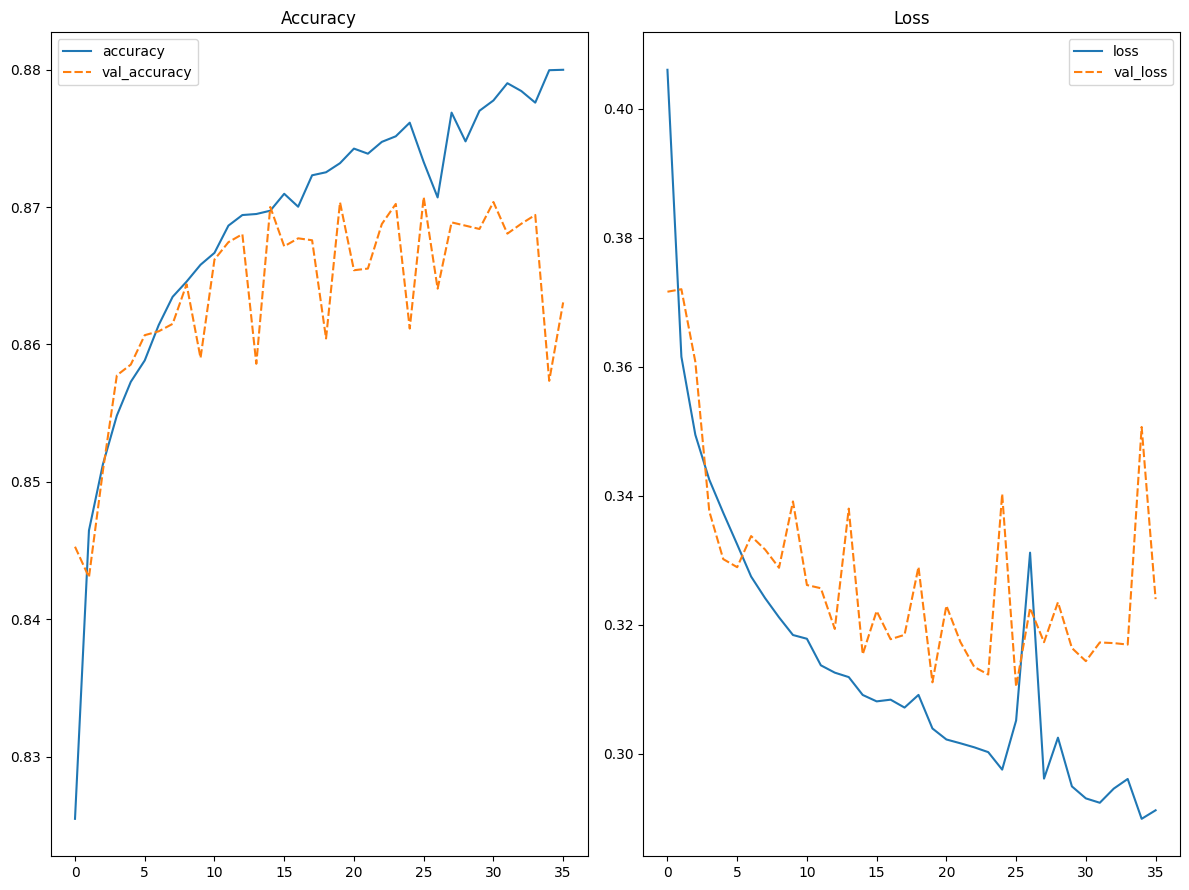

In [209]:
plt.figure(figsize=(12, 9))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse9[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse9[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [210]:
# Step 1: Make predictions
y_pred_probs9 = model9.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred9 = np.argmax(y_pred_probs9, axis=1)

# Step 4: Get true class labels
y_true9 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat9 = confusion_matrix(y_true9, y_pred9)

2776/2776 [==============================] - 16s 5ms/step


In [253]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat9[0, 0]
FP = confusion_mat9[0, 1]
FN = confusion_mat9[1, 0]
TP = confusion_mat9[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy9 = (TP + TN) / (TP + TN + FP + FN)
precision9 = TP / (TP + FP)
recall9 = TP / (TP + FN)
f1_score9 = 2 * (precision9 * recall9) / (precision9 + recall9)

print("Accuracy:", accuracy9)
print("Precision:", precision9)
print("Recall:", recall9)
print("F1 Score:", f1_score9)

Accuracy: 0.5006125684635342
Precision: 0.5005007363770251
Recall: 0.6122801960219083
F1 Score: 0.5507763119509902


In [212]:
model9.evaluate(testSet)

2776/2776 [==============================] - 15s 5ms/step - loss: 0.4214 - accuracy: 0.8167


[0.42138808965682983, 0.816697895526886]

## 10

In [221]:
# Define the CNN architecture
model10 = Sequential()
model10.add(Conv2D(32, (4, 4), activation='relu', input_shape=(50, 50, 3)))
model10.add(MaxPooling2D())

model10.add(Conv2D(64, (4, 4), activation='relu'))
model10.add(MaxPooling2D())

model10.add(Conv2D(128, (4, 4), activation='relu'))
model10.add(MaxPooling2D())

model10.add(Conv2D(256, (2, 2), activation='relu'))
model10.add(MaxPooling2D())
             
model10.add(Flatten())
             
model10.add(Dense(256, activation='relu'))
model10.add(Dense(2, activation='softmax'))

# Compile the model
model10.compile('adam',loss=BinaryCrossentropy(),metrics=['accuracy'])


In [222]:
model10.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 47, 47, 32)        1568      
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_119 (Conv2D)         (None, 20, 20, 64)        32832     
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 7, 7, 128)         131200    
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 3, 3, 128)      

In [223]:
history10 = model10.fit(trainSet, validation_data=validationSet, epochs=50, verbose=1, callbacks=earlyStopping)

Epoch 1/50
19982/19982 [==============================] - 195s 10ms/step - loss: 0.4160 - accuracy: 0.8192 - val_loss: 0.3804 - val_accuracy: 0.8384
Epoch 2/50
19982/19982 [==============================] - 191s 9ms/step - loss: 0.3799 - accuracy: 0.8367 - val_loss: 0.3645 - val_accuracy: 0.8458
Epoch 3/50
19982/19982 [==============================] - 169s 8ms/step - loss: 0.3651 - accuracy: 0.8442 - val_loss: 0.3530 - val_accuracy: 0.8508
Epoch 4/50
19982/19982 [==============================] - 168s 8ms/step - loss: 0.3565 - accuracy: 0.8483 - val_loss: 0.3516 - val_accuracy: 0.8471
Epoch 5/50
19982/19982 [==============================] - 156s 8ms/step - loss: 0.3499 - accuracy: 0.8517 - val_loss: 0.3571 - val_accuracy: 0.8473
Epoch 6/50
19982/19982 [==============================] - 166s 8ms/step - loss: 0.3444 - accuracy: 0.8546 - val_loss: 0.3436 - val_accuracy: 0.8551
Epoch 7/50
19982/19982 [==============================] - 165s 8ms/step - loss: 0.3396 - accuracy: 0.8558 - val

In [224]:
losse10 = pd.DataFrame(history10.history)
losse10.head()

loss  accuracy  val_loss  val_accuracy
0  0.415981  0.819240  0.380388      0.838395
1  0.379852  0.836656  0.364474      0.845841
2  0.365098  0.844192  0.352987      0.850786
3  0.356519  0.848346  0.351594      0.847082
4  0.349865  0.851704  0.357097      0.847263

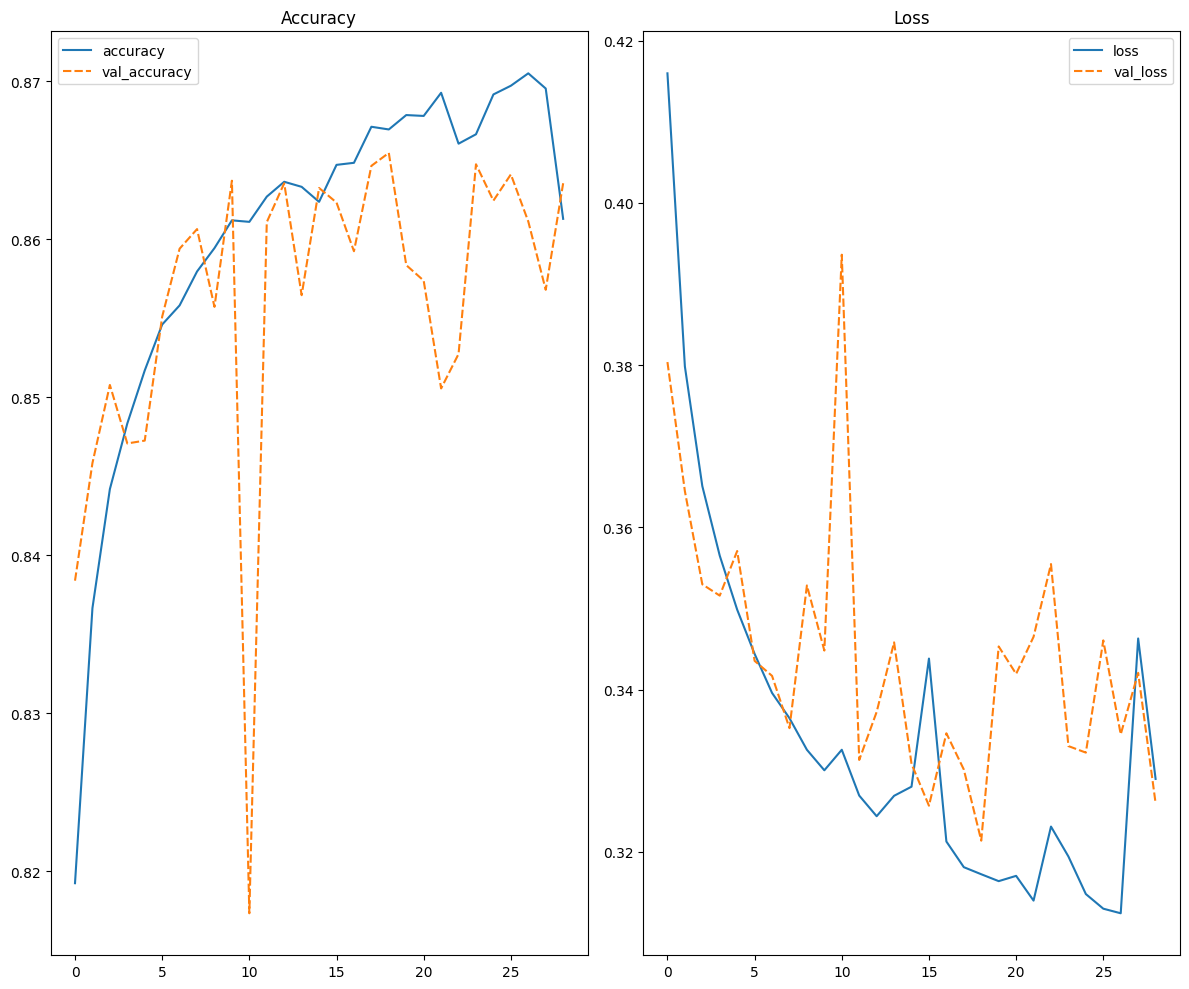

In [225]:
plt.figure(figsize=(12, 10))

# Plot accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=losse10[['accuracy', 'val_accuracy']])
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
sns.lineplot(data=losse10[['loss', 'val_loss']])
plt.title('Loss')

plt.tight_layout()
plt.show()

In [226]:
# Step 1: Make predictions
y_pred_probs10 = model10.predict(testSet)

# Step 2: Convert predicted probabilities to class labels
y_pred10 = np.argmax(y_pred_probs10, axis=1)

# Step 4: Get true class labels
y_true10 = testSet.labels

# Step 4: Create confusion matrix
confusion_mat10 = confusion_matrix(y_true10, y_pred10)

2776/2776 [==============================] - 33s 11ms/step


In [258]:
# Calculate true positives, false negatives, and false positives from the confusion matrix
TN = confusion_mat10[0, 0]
FP = confusion_mat10[0, 1]
FN = confusion_mat10[1, 0]
TP = confusion_mat10[1, 1]



# Calculate accuracy, precision, recall, and F1 score
accuracy10 = (TP + TN) / (TP + TN + FP + FN)
precision10 = TP / (TP + FP)
recall10 = TP / (TP + FN)
f1_score10 = 2 * (precision10 * recall10) / (precision10 + recall10)

print("Accuracy:", accuracy10)
print("Precision:", precision10)
print("Recall:", recall10)
print("F1 Score:", f1_score10)

Accuracy: 0.49909916402421445
Precision: 0.49927624341381505
Recall: 0.6214326895358893
F1 Score: 0.5536969852634284


In [228]:
model10.evaluate(testSet)

2776/2776 [==============================] - 19s 6ms/step - loss: 0.4278 - accuracy: 0.8096


[0.4278179109096527, 0.8095632791519165]

## Comparing the modified models based on model 1

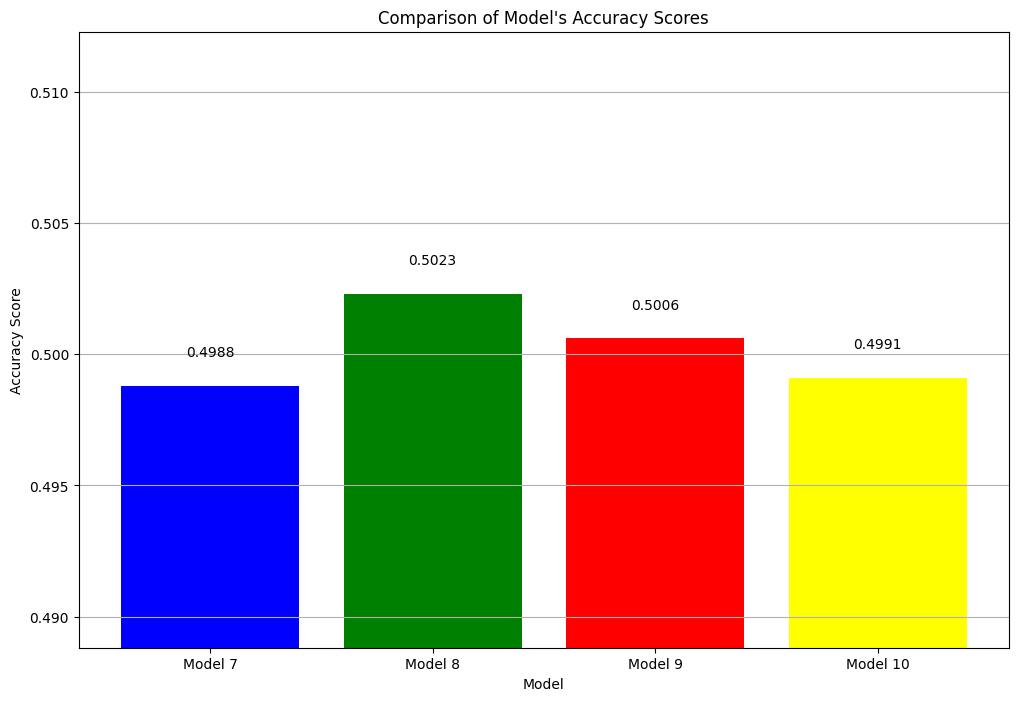

In [336]:
model_names = ['Model 7', 'Model 8', 'Model 9', 'Model 10']
accuracy_scores = [accuracy7, accuracy8, accuracy9,accuracy10] 
minLimit = min(accuracy_scores)
maxLimit = max(accuracy_scores)

# Create the bar chart
plt.figure(figsize=(12, 8))  

# Plot the accuracy scores as bars
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'red','Yellow'])

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title("Comparison of Model's Accuracy Scores")

for x, y in zip(model_names, accuracy_scores):
    plt.text(x, y + 0.001, f'{y:.4}', ha='center', va='bottom')
    
# Show the chart
plt.ylim(minLimit-0.01, maxLimit+0.01)  # Set the y-axis limits 
plt.grid(axis='y')
plt.show()

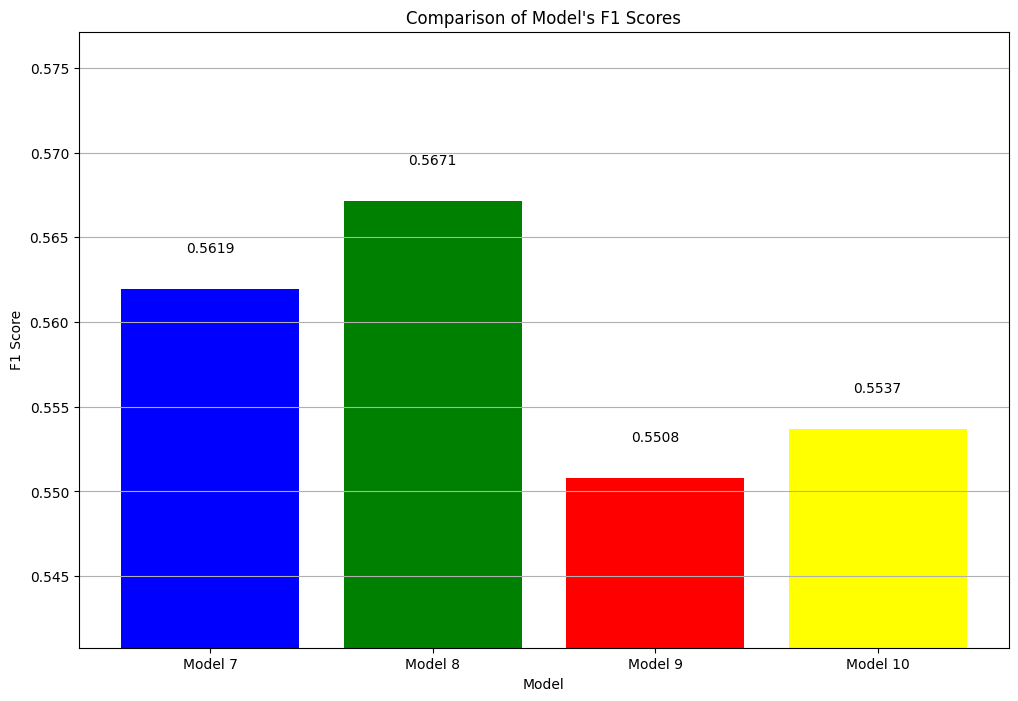

In [339]:
f1_scores = [f1_score7, f1_score8, f1_score9, f1_score10] 
minLimit = min(f1_scores)
maxLimit = max(f1_scores)

# Create the bar chart
plt.figure(figsize=(12, 8))  

# Plot the accuracy scores as bars
plt.bar(model_names, f1_scores, color=['blue', 'green', 'red','Yellow'])

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title("Comparison of Model's F1 Scores")

for x, y in zip(model_names, f1_scores):
    plt.text(x, y + 0.002, f'{y:.4}', ha='center', va='bottom')

# Show the chart
plt.ylim(minLimit-0.01, maxLimit+0.01)  # Set the y-axis limits 
plt.grid(axis='y')
plt.show()

Based on the charts model 8 has the highest accuracy and F1-score. hence it will be chosen as our final model to be used.

#  Testing the finalised model

In [294]:
model8.save('FinalModel')

INFO:tensorflow:Assets written to: FinalModel\assets


INFO:tensorflow:Assets written to: FinalModel\assets


In [295]:
loadedFinalModel = load_model("FinalModel")

In [327]:
class FinalModel:
    def __init__(self, filePath):
        self.filePath = filePath

    def prediction_function(self):
         # Load test images from the specified directory
        finalTestSet = dataGeneration.flow_from_directory(
            self.filePath,
            target_size=(50, 50),
            batch_size=10,
            class_mode='categorical')

        class_labels = finalTestSet.class_indices
        # Modify class labels in the data generator to match classes
        class_labels = {'ones': 1, 'zeros': 0}
        finalTestSet.class_indices = class_labels
        test_labels = finalTestSet.class_indices
        
        # Make predictions on the test images
        predictions = loadedFinalModel.predict(finalTestSet)
        results = []
        
        # Iterate through the predictions and associate each with its filename
        for i, (filename, prediction) in enumerate(zip(finalTestSet.filenames, predictions)):
            has_cancer = '{}: The percentage of cancer : {:.2f}%'.format(filename, prediction[1] * 100)          
            results.append((has_cancer))
            
        return results

In [335]:
finalModel = FinalModel("E:\FYP\dataset\\finaltest")
results = finalModel.prediction_function()

for result in results:
    print(result)

Found 20 images belonging to 2 classes.
2/2 [==============================] - 0s 11ms/step
ones\8863_idx5_x1051_y1001_class1.png: The percentage of cancer : 99.87%
ones\8863_idx5_x1051_y1501_class1.png: The percentage of cancer : 99.89%
ones\8863_idx5_x1051_y1551_class1.png: The percentage of cancer : 98.18%
ones\8863_idx5_x1101_y1101_class1.png: The percentage of cancer : 14.25%
ones\8863_idx5_x1101_y1151_class1.png: The percentage of cancer : 32.41%
ones\8863_idx5_x1151_y1651_class1.png: The percentage of cancer : 51.10%
ones\8863_idx5_x1251_y1051_class1.png: The percentage of cancer : 99.93%
ones\8863_idx5_x1251_y1501_class1.png: The percentage of cancer : 99.99%
ones\8863_idx5_x1251_y1551_class1.png: The percentage of cancer : 96.99%
ones\8863_idx5_x1251_y901_class1.png: The percentage of cancer : 22.13%
zeros\8863_idx5_x151_y1151_class0.png: The percentage of cancer : 20.04%
zeros\8863_idx5_x251_y1151_class0.png: The percentage of cancer : 3.57%
zeros\8863_idx5_x251_y451_class0.p